# 오늘의 IRS 금리를 부트스트래핑해 P(0,T)구하기(현재의 제로쿠폰채권가격)

IRS 금리 부트스트래핑 - P(0,T) 계산

[1단계] Par 금리 보간 (Cubic Spline)
✓ 1년부터 30년까지 보간 완료

[2단계] 할인계수 부트스트랩 (고정 다리 빈도: 1회/년)
✓ 30개 만기의 할인계수 계산 완료

부트스트랩 결과
 T (yrs)   Par S_T (%)        P(0,T)   Zero y_simple (%)   Zero z_cont (%)
----------------------------------------------------------------------
       1        3.6490    0.96479464            3.649000          3.584000
       2        3.3950    0.93548549            3.390699          3.334482
       3        3.3350    0.90639731            3.330167          3.275918
       4        3.3368    0.87708150            3.333232          3.278884
       5        3.3580    0.84782927            3.356625          3.301520
       6        3.3996    0.81813352            3.402086          3.345495
       7        3.4520    0.78812165            3.459980          3.401469
       8        3.5053    0.75827102            3.519447          3.458930
       9        3.5571    0.72877552            3.577961          3.515439
      10        3.6070    0.69973093

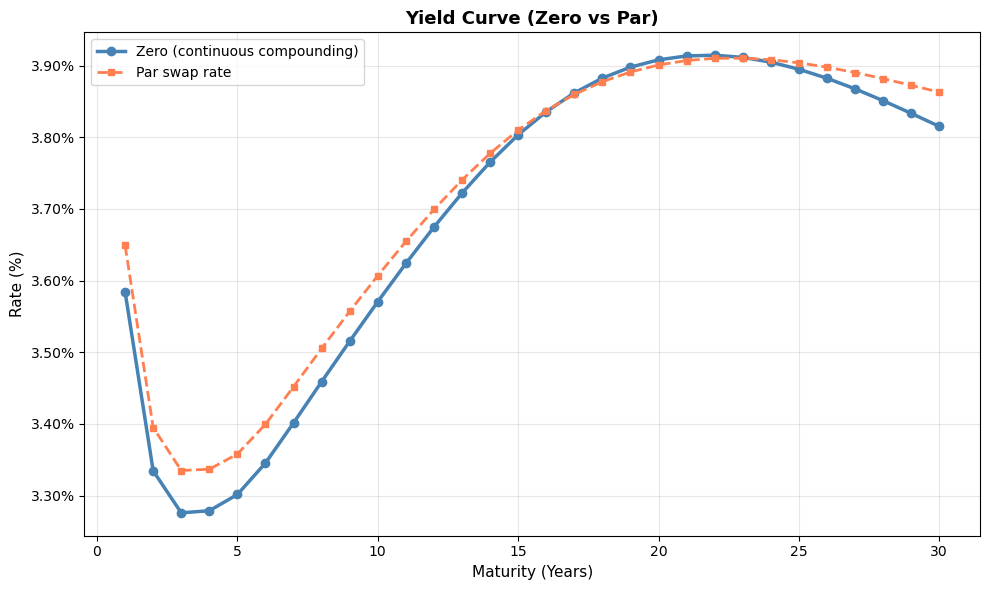


부트스트래핑 완료! 다음 단계를 진행하세요.

반환된 변수:
  - P_year: 할인계수 딕셔너리 {T: P(0,T)}
  - par_full: 보간된 Par 금리 딕셔너리 {T: S_T}


In [1]:
import numpy as np
from math import log, exp
import csv
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
# 모든 설정 완전 초기화
plt.rcdefaults()

# =============================================================================
# USER INPUT
# =============================================================================
PAR_RATES_PCT = {
    1: 3.649,
    2: 3.395,
    3: 3.335,
    5: 3.358,
    7: 3.452,
    10: 3.607,
    15: 3.810,
    30: 3.863,
}
FREQ = 1   # 고정 다리 지급 빈도 (1=연 1회, 2=연 2회)

# =============================================================================
# Helper Functions
# =============================================================================
def fill_annual_par_curve_cubic(par_rates_pct):
    """Cubic Spline을 사용하여 누락된 연간 Par 금리를 보간"""
    known = sorted((int(T), v / 100.0) for T, v in par_rates_pct.items())
    known_T = [kv[0] for kv in known]
    known_S = [kv[1] for kv in known]
    maxT = known_T[-1]

    # bc_type='natural'로 외삽 시 과도한 변동 방지
    spline = CubicSpline(known_T, known_S, bc_type='natural')
    all_T = range(1, maxT + 1)
    all_S = spline(all_T)

    return dict(zip(all_T, all_S))

def make_coupon_times(T, freq):
    """스왑의 쿠폰 지급 시점 생성"""
    delta = 1.0 / freq
    n = int(round(T * freq))
    return [i * delta for i in range(1, n + 1)], delta

def get_P_interpolator(P_year):
    """현재까지 알려진 할인계수 기반 보간 함수 생성 (log-linear)"""
    known_points = sorted([(0, 1.0)] + list(P_year.items()))

    if len(known_points) < 2:
        return P_year.get

    known_T = [p[0] for p in known_points]
    known_lnP = [log(p[1]) for p in known_points]

    # log(P)를 스플라인 보간하여 양의 할인계수 보장
    spline = CubicSpline(known_T, known_lnP, bc_type='natural')

    return lambda t: exp(spline(t))

# =============================================================================
# Core Bootstrap
# =============================================================================
def bootstrap_discounts_from_par(par_rates_dec, freq=1):
    """
    Par 금리로부터 할인계수 P(0,T) 부트스트랩

    스왑 밸류에이션:
    고정 다리: Σ S·δ·P(0,ti) + P(0,T)
    변동 다리: 1 (at inception, par swap)

    따라서: 1 = Σ S·δ·P(0,ti) + P(0,T)
    => P(0,T) = [1 - S·δ·Σ P(0,ti)] / (1 + S·δ) (마지막 항 제외)
    """
    P_year = {}

    for T in sorted(par_rates_dec.keys()):
        S = par_rates_dec[T]  # Par swap rate (decimal)
        coupon_times, delta = make_coupon_times(T, freq)

        # 이전까지 구한 할인계수로 보간 함수 생성
        P_interpolator = get_P_interpolator(P_year)

        # 마지막 시점을 제외한 쿠폰 지급의 현재가치 합
        known_sum = sum(P_interpolator(ti) for ti in coupon_times[:-1])

        # 마지막 시점 T의 할인계수 계산
        # 1 = S·δ·known_sum + S·δ·P(T) + P(T)
        # 1 = S·δ·known_sum + P(T)·(1 + S·δ)
        numerator = 1.0 - S * delta * known_sum
        denom = 1.0 + S * delta
        P_T = numerator / denom

        P_year[T] = P_T

    return P_year

# =============================================================================
# Visualization
# =============================================================================
def plot_yield_curve(par_full, P_year, which="cont",
                     title="Yield Curve (Zero vs Par)"):
    """수익률 곡선 시각화"""
    Tz = np.array(sorted(P_year.keys()), dtype=float)
    Pz = np.array([P_year[int(T)] for T in Tz], dtype=float)

    # Zero rate 계산
    if which == "cont":
        zero = -np.log(Pz) / Tz
        label_zero = "Zero (continuous compounding)"
    elif which == "simple":
        zero = Pz**(-1.0 / Tz) - 1.0
        label_zero = "Zero (simple compounding)"
    else:
        raise ValueError("which must be 'cont' or 'simple'")

    # Par rate
    Tp = np.array(sorted(par_full.keys()), dtype=float)
    Spar = np.array([par_full[int(T)] for T in Tp], dtype=float)

    # 플롯
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(Tz, 100*zero, marker="o", lw=2.5, label=label_zero,
            markersize=6, color='steelblue')
    ax.plot(Tp, 100*Spar, linestyle="--", marker="s", lw=2,
            label="Par swap rate", markersize=5, color='coral')

    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_xlabel("Maturity (Years)", fontsize=11)
    ax.set_ylabel("Rate (%)", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

# =============================================================================
# Main Execution
# =============================================================================
def main():
    print("=" * 70)
    print("IRS 금리 부트스트래핑 - P(0,T) 계산")
    print("=" * 70)

    # 1) Par 금리 보간
    print(f"\n[1단계] Par 금리 보간 (Cubic Spline)")
    par_full = fill_annual_par_curve_cubic(PAR_RATES_PCT)
    print(f"✓ 1년부터 {max(par_full.keys())}년까지 보간 완료")

    # 2) 부트스트랩 실행
    print(f"\n[2단계] 할인계수 부트스트랩 (고정 다리 빈도: {FREQ}회/년)")
    P_year = bootstrap_discounts_from_par(par_full, freq=FREQ)
    print(f"✓ {len(P_year)}개 만기의 할인계수 계산 완료")

    # 3) 결과 출력
    print("\n" + "=" * 70)
    print("부트스트랩 결과")
    print("=" * 70)

    header = ["T (yrs)", "Par S_T (%)", "P(0,T)",
              "Zero y_simple (%)", "Zero z_cont (%)"]
    rows = []

    for T in sorted(P_year.keys()):
        PT = P_year[T]
        y_simple = PT ** (-1.0 / T) - 1.0  # (1+y)^T = 1/P
        z_cc = -log(PT) / T                 # e^(-z*T) = P
        rows.append([T, 100.0 * par_full[T], PT,
                    100.0 * y_simple, 100.0 * z_cc])

    print("{:>8}  {:>12}  {:>12}  {:>18}  {:>16}".format(*header))
    print("-" * 70)
    for r in rows:
        print("{:8.0f}  {:12.4f}  {:12.8f}  {:18.6f}  {:16.6f}".format(*r))

    # 4) 주요 통계
    print("\n" + "=" * 70)
    print("주요 통계")
    print("=" * 70)

    zero_rates_cc = [-log(P_year[T]) / T for T in sorted(P_year.keys())]
    par_rates = [par_full[T] for T in sorted(par_full.keys())]

    print(f"Par 금리 범위: {min(par_rates)*100:.3f}% ~ {max(par_rates)*100:.3f}%")
    print(f"Zero 금리 범위 (연속): {min(zero_rates_cc)*100:.3f}% ~ {max(zero_rates_cc)*100:.3f}%")
    print(f"P(0,1): {P_year[1]:.8f}")
    print(f"P(0,10): {P_year[10]:.8f}")
    print(f"P(0,30): {P_year[30]:.8f}")

    # 5) CSV 저장
    csv_filename = "bootstrapped_discounts.csv"
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(rows)
    print(f"\n✓ 결과가 '{csv_filename}'에 저장되었습니다.")

    # 6) 그래프 표시
    print("\n[3단계] 수익률 곡선 시각화")
    plot_yield_curve(par_full, P_year, which="cont")

    return P_year, par_full

# =============================================================================
# Execute
# =============================================================================
if __name__ == "__main__":
    P_year, par_full = main()

    print("\n" + "=" * 70)
    print("부트스트래핑 완료! 다음 단계를 진행하세요.")
    print("=" * 70)
    print("\n반환된 변수:")
    print("  - P_year: 할인계수 딕셔너리 {T: P(0,T)}")
    print("  - par_full: 보간된 Par 금리 딕셔너리 {T: S_T}")

# 위의 제로금리를 바탕으로 선도금리함수를 만들고 phi 함수 구하기

G2++ φ(t) 함수 계산

사용 중인 G2++ 파라미터:
  a: 0.268
  b: 0.337
  sigma: 0.0179
  eta: 0.0144
  rho: 0.977

[1단계] 선도금리 및 φ(t) 함수 생성 중...
✓ 함수 생성 완료

[2단계] 샘플 값 출력

   t (년)      f(0,t) (%)        φ(t) (%)         차이 (bp)
     0.5          3.6062          3.6173            1.11
     1.0          3.3736          3.4121            3.86
     2.0          3.1300          3.2470           11.71
     3.0          3.0377          3.2407           20.30
     5.0          2.4204          2.7702           34.98
     7.0          2.1310          2.5796           44.86
    10.0          2.0796          2.6091           52.94
    15.0          1.6542          2.2316           57.73
    20.0          1.1308          1.7201           58.92
    30.0          0.7121          1.3050           59.29

[3단계] 시각화


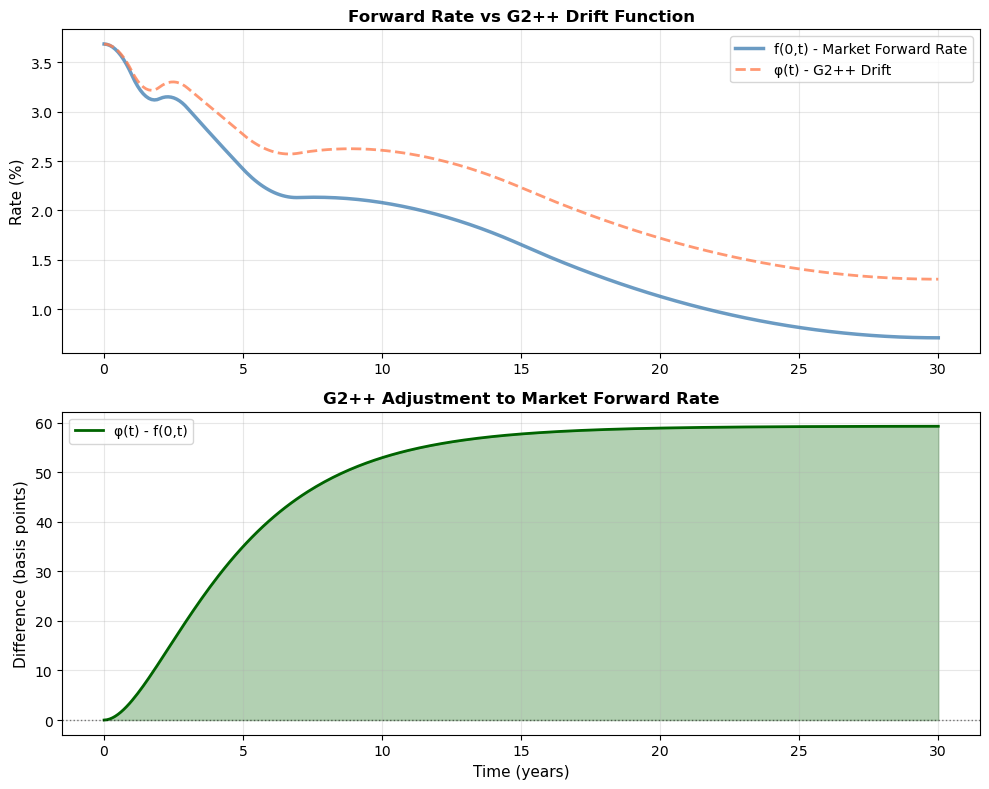


✓ φ(t) 함수 생성 완료!

다음 단계:
  1. G2++ 파라미터 보정 (스왑션 시장 데이터 사용)
  2. 몬테카를로로 r(t) = x(t) + y(t) + φ(t) 시뮬레이션
  3. CMS 스프레드 노트 가격결정

반환된 함수:
  - phi_func(t): φ(t) 값 반환
  - f0_func(t): f(0,t) 값 반환


In [2]:
"""
G2++ 모델의 φ(t) 함수 계산
- 시장 할인곡선 P(0,T)로부터 선도금리 f(0,t) 추출
- G2++ 파라미터를 사용하여 φ(t) 결정
"""

import numpy as np
from math import exp, log
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# =============================================================================
# 스플라인 및 선도금리 생성
# =============================================================================
def make_lnP_spline(P_year: dict):
    """
    입력: P_year = {T:int -> P(0,T):float}
    출력:
        - spline_lnP: log(P(t)) 스플라인 함수
        - f0: 순간 선도금리 f(0,t) = -d[ln P(0,t)]/dt
    """
    # (0, 1.0) 포함하여 자연스플라인 구성
    Ts = [0.0] + sorted(float(T) for T in P_year.keys())
    lnPs = [0.0] + [log(P_year[int(T)]) for T in sorted(P_year.keys())]

    # Natural boundary condition으로 외삽 안정화
    spline_lnP = CubicSpline(Ts, lnPs, bc_type="natural")
    spline_dlnP = spline_lnP.derivative()

    def f0(t: float) -> float:
        """
        순간 선도금리 f(0,t) (연속복리, 연 단위)
        f(0,t) = -d[ln P(0,t)]/dt
        """
        if t < 1e-9:
            # t=0에서는 우측 미분 근사
            dt = 1e-6
            return -float(spline_dlnP(dt))
        return -float(spline_dlnP(t))

    return spline_lnP, f0

# =============================================================================
# G2++ φ(t) 함수 생성
# =============================================================================
def phi_g2pp_factory(P_year: dict, a: float, b: float,
                     sigma: float, eta: float, rho: float):
    """
    G2++ 모델의 φ(t) 함수 생성

    파라미터:
        P_year: 시장 할인계수 딕셔너리
        a, b: mean reversion 속도 (1/년)
        sigma, eta: 변동성 (1/√년)
        rho: 상관계수

    반환:
        phi: φ(t) 함수
        f0: 순간 선도금리 f(0,t) 함수

    G2++ 모델:
        r(t) = x(t) + y(t) + φ(t)
        dx(t) = -a·x(t)dt + σ·dW₁(t)
        dy(t) = -b·y(t)dt + η·dW₂(t)
        dW₁·dW₂ = ρ·dt

    φ(t)는 다음을 만족:
        φ(t) = f^M(0,t) + (σ²/2a²)(1-e^(-at))² + (η²/2b²)(1-e^(-bt))²
                        + (ρση/ab)(1-e^(-at))(1-e^(-bt))
    """
    spline_lnP, f0 = make_lnP_spline(P_year)

    def phi(t: float) -> float:
        """φ(t) 함수"""
        if t < 1e-9:
            t = 1e-9  # 0으로 나누기 방지

        ea = exp(-a * t)
        eb = exp(-b * t)

        # x 프로세스 기여분
        term_x = (sigma**2) / (2.0 * a**2) * (1.0 - ea)**2

        # y 프로세스 기여분
        term_y = (eta**2) / (2.0 * b**2) * (1.0 - eb)**2

        # 상관 항
        cross = (rho * sigma * eta) / (a * b) * (1.0 - ea) * (1.0 - eb)

        return f0(t) + term_x + term_y + cross

    return phi, f0

# =============================================================================
# 시각화
# =============================================================================
def plot_forward_and_phi(phi_func, f0_func, max_T: float = 30.0):
    """선도금리 f(0,t)와 φ(t)를 한 그래프에 비교"""
    ts = np.linspace(0.01, max_T, 300)

    phi_vals = np.array([phi_func(t) for t in ts]) * 100
    f0_vals = np.array([f0_func(t) for t in ts]) * 100
    diff_vals = (phi_vals - f0_vals) * 100  # basis points

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # 상단: f(0,t)와 φ(t) 비교
    ax1.plot(ts, f0_vals, linewidth=2.5, color='steelblue', label='f(0,t) - Market Forward Rate', alpha=0.8)
    ax1.plot(ts, phi_vals, linewidth=2, color='coral', linestyle='--', label='φ(t) - G2++ Drift', alpha=0.8)
    ax1.set_ylabel("Rate (%)", fontsize=11)
    ax1.set_title("Forward Rate vs G2++ Drift Function", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, loc='best')

    # 하단: 차이 (φ(t) - f(0,t))
    ax2.plot(ts, diff_vals, linewidth=2, color='darkgreen', label='φ(t) - f(0,t)')
    ax2.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
    ax2.fill_between(ts, 0, diff_vals, alpha=0.3, color='darkgreen')
    ax2.set_xlabel("Time (years)", fontsize=11)
    ax2.set_ylabel("Difference (basis points)", fontsize=11)
    ax2.set_title("G2++ Adjustment to Market Forward Rate", fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10, loc='best')

    plt.tight_layout()
    plt.show()

# =============================================================================
# 메인 실행
# =============================================================================
def main(P_year: dict, g2_params: dict = None):
    """
    메인 함수

    입력:
        P_year: 할인계수 딕셔너리
        g2_params: G2++ 파라미터 (없으면 예시 값 사용)
    """
    print("=" * 70)
    print("G2++ φ(t) 함수 계산")
    print("=" * 70)

    # G2++ 파라미터 (예시 값 또는 보정된 값)
    if g2_params is None:
        print("\n⚠ G2++ 파라미터가 제공되지 않아 예시 값을 사용합니다.")
        g2_params = {
            'a': 0.03,
            'b': 0.10,
            'sigma': 0.007,
            'eta': 0.012,
            'rho': -0.75
        }

    print(f"\n사용 중인 G2++ 파라미터:")
    for key, val in g2_params.items():
        print(f"  {key}: {val}")

    # φ(t) 및 f(0,t) 함수 생성
    print(f"\n[1단계] 선도금리 및 φ(t) 함수 생성 중...")
    phi_func, f0_func = phi_g2pp_factory(
        P_year,
        a=g2_params['a'],
        b=g2_params['b'],
        sigma=g2_params['sigma'],
        eta=g2_params['eta'],
        rho=g2_params['rho']
    )
    print("✓ 함수 생성 완료")

    # 샘플 값 출력
    print(f"\n[2단계] 샘플 값 출력")
    print("\n" + "=" * 70)
    print(f"{'t (년)':>8}  {'f(0,t) (%)':>14}  {'φ(t) (%)':>14}  {'차이 (bp)':>14}")
    print("=" * 70)

    sample_times = [0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
    for t in sample_times:
        if t <= max(P_year.keys()):
            f0_val = f0_func(t) * 100
            phi_val = phi_func(t) * 100
            diff_bp = (phi_val - f0_val) * 100  # basis points
            print(f"{t:8.1f}  {f0_val:14.4f}  {phi_val:14.4f}  {diff_bp:14.2f}")

    # 시각화
    print(f"\n[3단계] 시각화")
    plot_forward_and_phi(phi_func, f0_func, max_T=max(P_year.keys()))

    print("\n" + "=" * 70)
    print("✓ φ(t) 함수 생성 완료!")
    print("=" * 70)
    print("\n다음 단계:")
    print("  1. G2++ 파라미터 보정 (스왑션 시장 데이터 사용)")
    print("  2. 몬테카를로로 r(t) = x(t) + y(t) + φ(t) 시뮬레이션")
    print("  3. CMS 스프레드 노트 가격결정")

    return phi_func, f0_func

# =============================================================================
# 사용 예시
# =============================================================================
if __name__ == "__main__":
    # 예시 P_year (실제로는 이전 단계에서 받아옴)
    P_year_example = {
        1: 0.964830,
        2: 0.934547,
        3: 0.905827,
        5: 0.857762,
        7: 0.820445,
        10: 0.769912,
        15: 0.700112,
        30: 0.600234
    }

    # 예시 G2++ 파라미터 (실제로는 보정 단계에서 받아옴)
    g2_params_example = {
        'a': 0.268,
        'b': 0.337,
        'sigma': 0.0179,
        'eta': 0.0144,
        'rho': 0.977
    }

    phi_func, f0_func = main(P_year_example, g2_params_example)

    print("\n반환된 함수:")
    print("  - phi_func(t): φ(t) 값 반환")
    print("  - f0_func(t): f(0,t) 값 반환")

# MOVE 지수를 이용해 현재의 스왑션 변동성 행렬을 만들기

In [3]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [3]:
"""
개선된 ATM 스왑션 표면 리스케일링
- Term structure 고려한 만기별 스케일링
- Tenor별 차등 조정
- 다중 앵커 포인트 지원
- 강화된 오류 처리
"""

import pandas as pd
import numpy as np
from datetime import date
import yfinance as yf
from pandas.tseries.offsets import BDay
from scipy.interpolate import RectBivariateSpline
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 설정
# =============================================================================
OLD_DATE_STR = "2018-04-16"      # 과거 표면 날짜
TARGET_DATE_STR = None           # None이면 오늘
USE_TERM_STRUCTURE = True        # 만기별 차등 스케일링
USE_TENOR_ADJUSTMENT = True      # 텐서별 차등 조정
USE_MULTIPLE_ANCHORS = False     # 다중 앵커 포인트 사용

# Term structure 파라미터
TERM_DECAY = 0.3                 # 만기 증가에 따른 MOVE 영향 감쇠 계수
                                 # 0.3: 2Y 만기는 1M 대비 약 60% 영향

# Tenor adjustment 파라미터
TENOR_SHORT_BOOST = 0.05         # 단기(≤5Y) 텐서 추가 조정 (+5%)
TENOR_LONG_DISCOUNT = -0.03      # 장기(>10Y) 텐서 조정 (-3%)

# 다중 앵커 포인트 (시장 데이터가 있을 경우)
ANCHOR_POINTS = {
    # (expiry, tenor): today_vol (decimal)
    # 예: ('3M', '10Y'): 0.215,
    #     ('1Y', '10Y'): 0.235,
    #     ('2Y', '10Y'): 0.250,
}

# =============================================================================
# 유틸리티 함수
# =============================================================================
def to_years(label: str) -> float:
    """만기/텐서 라벨을 연 단위로 변환"""
    label = label.strip().upper()
    if label.endswith("M"):
        return int(label[:-1]) / 12.0
    if label.endswith("Y"):
        return int(label[:-1]) * 1.0
    raise ValueError(f"Unknown label format: {label}")

def fetch_move_series_robust(start_ts: pd.Timestamp, end_ts: pd.Timestamp,
                              max_retries: int = 3) -> pd.Series:
    """MOVE 지수 데이터 다운로드 (재시도 로직 포함)"""
    for attempt in range(max_retries):
        try:
            # 충분한 버퍼를 두고 다운로드
            buffer_start = start_ts - BDay(20)
            buffer_end = end_ts + BDay(5)

            df = yf.download("^MOVE", start=buffer_start, end=buffer_end,
                           auto_adjust=False, progress=False)

            if df is None or df.empty:
                raise RuntimeError("MOVE download returned empty data")

            # Adj Close 또는 Close 컬럼 선택
            if "Adj Close" in df.columns:
                col = "Adj Close"
            elif "Close" in df.columns:
                col = "Close"
            else:
                raise RuntimeError(f"Expected columns not found: {df.columns.tolist()}")

            # 일별 마지막 값 추출
            s = df[col]
            s = s.groupby(s.index.date).last()
            s.index = pd.to_datetime(s.index)

            # 데이터 검증
            if len(s) < 5:
                raise RuntimeError(f"Insufficient MOVE data: only {len(s)} points")

            return s

        except Exception as e:
            if attempt < max_retries - 1:
                print(f"  ⚠ Attempt {attempt + 1} failed: {e}. Retrying...")
                continue
            else:
                raise RuntimeError(f"Failed to fetch MOVE data after {max_retries} attempts: {e}")

def nearest_business_value(series: pd.Series, ts: pd.Timestamp,
                           max_lookback_days: int = 10) -> float:
    """가장 가까운 비즈니스 데이의 값 추출"""
    s = series.dropna()

    if ts in s.index:
        return float(s.loc[ts])

    # 이전 데이터 찾기
    prev_indices = s.index[s.index <= ts]

    if len(prev_indices) == 0:
        raise ValueError(f"No MOVE data on or before {ts.date()}")

    nearest_date = prev_indices.max()
    days_diff = (ts - nearest_date).days

    if days_diff > max_lookback_days:
        print(f"  ⚠ Warning: Using MOVE data from {days_diff} days ago ({nearest_date.date()})")

    return float(s.loc[nearest_date])

# =============================================================================
# 스케일링 함수
# =============================================================================
def calculate_term_adjusted_k(expiry_label: str, k_base: float, decay: float) -> float:
    """
    만기별 조정된 스케일링 계수
    - 단기: MOVE 비율을 거의 그대로 반영
    - 장기: MOVE 영향 감쇠
    """
    T = to_years(expiry_label)
    # k_adjusted = k_base ^ (1 / (1 + decay * T))
    # 예: T=0 → k, T=2 → k^0.625 (decay=0.3일 때)
    adjusted_k = k_base ** (1 / (1 + decay * T))
    return adjusted_k

def calculate_tenor_adjustment_factor(tenor_label: str, short_boost: float,
                                     long_discount: float) -> float:
    """
    텐서별 조정 계수
    - 단기 텐서 (≤5Y): 변동성이 더 민감하게 반응
    - 장기 텐서 (>10Y): 변동성이 덜 민감
    """
    tenor_years = to_years(tenor_label)

    if tenor_years <= 5:
        return 1.0 + short_boost
    elif tenor_years > 10:
        return 1.0 + long_discount
    else:
        # 5Y~10Y는 선형 보간
        weight = (tenor_years - 5) / 5  # 0 to 1
        factor = (1 + short_boost) * (1 - weight) + (1 + long_discount) * weight
        return factor

def create_scaling_matrix(expiries: list, tenors: list, k_base: float,
                         use_term: bool = True, use_tenor: bool = True,
                         term_decay: float = 0.3,
                         tenor_short_boost: float = 0.05,
                         tenor_long_discount: float = -0.03) -> pd.DataFrame:
    """
    2D 스케일링 행렬 생성 (만기 × 텐서)
    """
    k_matrix = pd.DataFrame(index=expiries, columns=tenors, dtype=float)

    for exp in expiries:
        for ten in tenors:
            k = k_base

            # 만기별 조정
            if use_term:
                k = calculate_term_adjusted_k(exp, k, term_decay)

            # 텐서별 조정
            if use_tenor:
                tenor_factor = calculate_tenor_adjustment_factor(
                    ten, tenor_short_boost, tenor_long_discount
                )
                k *= tenor_factor

            k_matrix.loc[exp, ten] = k

    return k_matrix

def apply_multiple_anchors(vol_scaled: pd.DataFrame,
                          anchor_points: dict) -> pd.DataFrame:
    """
    다중 앵커 포인트를 사용하여 표면 조정
    2D 스플라인 보간으로 부드러운 조정
    """
    if not anchor_points:
        return vol_scaled

    print(f"\n[다중 앵커 조정] {len(anchor_points)}개 포인트 사용")

    # 앵커 포인트에서 조정 비율 계산
    adjustment_ratios = {}
    for (exp, ten), target_vol in anchor_points.items():
        if exp in vol_scaled.index and ten in vol_scaled.columns:
            model_vol = vol_scaled.loc[exp, ten]
            ratio = target_vol / model_vol
            adjustment_ratios[(exp, ten)] = ratio
            print(f"  {exp}×{ten}: {model_vol:.4f} → {target_vol:.4f} (ratio={ratio:.4f})")

    if len(adjustment_ratios) < 2:
        # 앵커가 1개 이하면 단순 비율 조정
        if len(adjustment_ratios) == 1:
            ratio = list(adjustment_ratios.values())[0]
            return vol_scaled * ratio
        return vol_scaled

    # 2D 그리드 생성
    expiry_years = [to_years(e) for e in vol_scaled.index]
    tenor_years = [to_years(t) for t in vol_scaled.columns]

    # 앵커 포인트 좌표
    anchor_exp_years = [to_years(exp) for (exp, ten) in adjustment_ratios.keys()]
    anchor_ten_years = [to_years(ten) for (exp, ten) in adjustment_ratios.keys()]
    anchor_ratios = list(adjustment_ratios.values())

    # 2D 보간 (RBF 또는 스플라인)
    from scipy.interpolate import Rbf
    rbf = Rbf(anchor_exp_years, anchor_ten_years, anchor_ratios, function='multiquadric', smooth=0.1)

    # 전체 그리드에 대해 조정 비율 계산
    adjustment_grid = np.zeros((len(expiry_years), len(tenor_years)))
    for i, exp_y in enumerate(expiry_years):
        for j, ten_y in enumerate(tenor_years):
            adjustment_grid[i, j] = rbf(exp_y, ten_y)

    # 조정 적용
    vol_adjusted = vol_scaled * adjustment_grid

    return vol_adjusted

# =============================================================================
# 메인 로직
# =============================================================================
def main():
    print("=" * 70)
    print("개선된 ATM 스왑션 표면 리스케일링")
    print("=" * 70)

    # 2018-04-16 ATM 표면 데이터 (Black, %)
    expiries = ["1M", "3M", "6M", "1Y", "2Y"]
    tenors = ["1Y", "2Y", "5Y", "10Y", "15Y", "20Y", "30Y"]

    data_2018_04_16_pct = [
        [12.4559, 15.6906, 18.5884, 18.7795, 18.0630, 17.7101, 17.5578],  # 1M
        [14.1064, 17.1848, 19.5244, 19.6338, 18.9183, 18.5667, 18.4021],  # 3M
        [15.3294, 18.1170, 20.7427, 20.7399, 19.9287, 19.5322, 19.3833],  # 6M
        [17.7833, 20.1802, 22.1637, 21.9932, 21.0658, 20.5908, 20.3785],  # 1Y
        [22.1572, 23.2539, 23.9005, 23.0334, 21.9114, 21.2860, 21.0047],  # 2Y
    ]

    vol_old = pd.DataFrame(
        np.array(data_2018_04_16_pct) / 100.0,
        index=expiries,
        columns=tenors
    )

    print(f"\n[원본 표면] 2018-04-16")
    print(vol_old.multiply(100).round(2))

    # 날짜 설정
    old_date = pd.Timestamp(OLD_DATE_STR)
    target_date = pd.Timestamp(TARGET_DATE_STR) if TARGET_DATE_STR else pd.Timestamp(date.today())

    print(f"\n[날짜 정보]")
    print(f"  과거 날짜: {old_date.date()}")
    print(f"  목표 날짜: {target_date.date()}")

    # MOVE 지수 다운로드
    print(f"\n[MOVE 지수 다운로드]")
    try:
        move_series = fetch_move_series_robust(old_date, target_date)
        print(f"  ✓ {len(move_series)}개 데이터 포인트 확보")
    except Exception as e:
        print(f"  ✗ MOVE 다운로드 실패: {e}")
        return

    # MOVE 값 추출
    try:
        MOVE_old = nearest_business_value(move_series, old_date)
        MOVE_new = nearest_business_value(move_series, target_date)
    except ValueError as e:
        print(f"  ✗ MOVE 값 추출 실패: {e}")
        return

    k_base = MOVE_new / MOVE_old

    print(f"\n[MOVE 비율]")
    print(f"  MOVE({old_date.date()}): {MOVE_old:.2f}")
    print(f"  MOVE({target_date.date()}): {MOVE_new:.2f}")
    print(f"  기본 스케일 k: {k_base:.6f}")

    # 2D 스케일링 행렬 생성
    print(f"\n[스케일링 행렬 생성]")
    print(f"  Term structure 조정: {USE_TERM_STRUCTURE} (decay={TERM_DECAY})")
    print(f"  Tenor 조정: {USE_TENOR_ADJUSTMENT} (short={TENOR_SHORT_BOOST}, long={TENOR_LONG_DISCOUNT})")

    k_matrix = create_scaling_matrix(
        expiries, tenors, k_base,
        use_term=USE_TERM_STRUCTURE,
        use_tenor=USE_TENOR_ADJUSTMENT,
        term_decay=TERM_DECAY,
        tenor_short_boost=TENOR_SHORT_BOOST,
        tenor_long_discount=TENOR_LONG_DISCOUNT
    )

    print(f"\n스케일링 행렬 (k values):")
    print(k_matrix.round(4))

    # 변동성 스케일링
    vol_scaled = vol_old * k_matrix

    # 다중 앵커 조정 (선택사항)
    if USE_MULTIPLE_ANCHORS and ANCHOR_POINTS:
        vol_final = apply_multiple_anchors(vol_scaled, ANCHOR_POINTS)
    else:
        vol_final = vol_scaled

    # 결과 출력
    print(f"\n" + "=" * 70)
    print("최종 리스케일된 표면 (%)")
    print("=" * 70)
    print(vol_final.multiply(100).round(4))

    # 통계 정보
    print(f"\n" + "=" * 70)
    print("변화 통계")
    print("=" * 70)
    change_pct = ((vol_final / vol_old - 1) * 100)
    print(f"평균 변화율: {change_pct.mean().mean():.2f}%")
    print(f"최소 변화율: {change_pct.min().min():.2f}%")
    print(f"최대 변화율: {change_pct.max().max():.2f}%")

    # 만기별 평균 변화
    print(f"\n만기별 평균 변화율:")
    for exp in expiries:
        avg_change = change_pct.loc[exp].mean()
        print(f"  {exp:>3}: {avg_change:>6.2f}%")

    # 텐서별 평균 변화
    print(f"\n텐서별 평균 변화율:")
    for ten in tenors:
        avg_change = change_pct[ten].mean()
        print(f"  {ten:>3}: {avg_change:>6.2f}%")

    # Python 리스트 형태로 출력 (복사 & 붙여넣기용)
    print(f"\n" + "=" * 70)
    print("🎯 복사해서 사용하세요!")
    print("=" * 70)
    print("\nrescaled_surface_pct = [")
    for exp in vol_final.index:
        row = [100.0 * vol_final.loc[exp, ten] for ten in vol_final.columns]
        row_str = ", ".join(f"{x:.4f}" for x in row)
        print(f"    [{row_str}],  # {exp}")
    print(f"]  # columns: {', '.join(tenors)}")
    print("")

    return vol_final

# =============================================================================
# 실행
# =============================================================================
if __name__ == "__main__":
    result = main()

개선된 ATM 스왑션 표면 리스케일링

[원본 표면] 2018-04-16
       1Y     2Y     5Y    10Y    15Y    20Y    30Y
1M  12.46  15.69  18.59  18.78  18.06  17.71  17.56
3M  14.11  17.18  19.52  19.63  18.92  18.57  18.40
6M  15.33  18.12  20.74  20.74  19.93  19.53  19.38
1Y  17.78  20.18  22.16  21.99  21.07  20.59  20.38
2Y  22.16  23.25  23.90  23.03  21.91  21.29  21.00

[날짜 정보]
  과거 날짜: 2018-04-16
  목표 날짜: 2025-10-08

[MOVE 지수 다운로드]



1 Failed download:
['^MOVE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


  ⚠ Attempt 1 failed: MOVE download returned empty data. Retrying...



1 Failed download:
['^MOVE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


  ⚠ Attempt 2 failed: MOVE download returned empty data. Retrying...



1 Failed download:
['^MOVE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


  ✗ MOVE 다운로드 실패: Failed to fetch MOVE data after 3 attempts: MOVE download returned empty data


# 위에서 만든 스왑션 변동성 행렬에 fitting 하는 파라미터 찾기(by 최적화)...

In [5]:
import numpy as np
from math import log, exp, sqrt
import csv
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar, minimize
from scipy.stats import norm
from functools import lru_cache
from joblib import Parallel, delayed
import time

# =============================================================================
# 0. 부트스트랩 (이전과 동일)
# =============================================================================
PAR_RATES_PCT = {
    1: 3.649, 2: 3.395, 3: 3.335, 5: 3.358,
    7: 3.452, 10: 3.607, 15: 3.810, 30: 3.863,
}

def fill_annual_par_curve_cubic(par_rates_pct):
    known = sorted((int(T), v / 100.0) for T, v in par_rates_pct.items())
    known_T, known_S = [kv[0] for kv in known], [kv[1] for kv in known]
    maxT = known_T[-1]
    spline = CubicSpline(known_T, known_S, bc_type='natural')
    return dict(zip(range(1, maxT + 1), spline(range(1, maxT + 1))))

def make_coupon_times(T, freq):
    delta = 1.0 / freq
    return [i * delta for i in range(1, int(round(T * freq)) + 1)], delta

def get_P_interpolator(P_year):
    known_points = sorted([(0, 1.0)] + list(P_year.items()))
    if len(known_points) < 2: return P_year.get
    known_T, known_lnP = [p[0] for p in known_points], [log(p[1]) for p in known_points]
    spline = CubicSpline(known_T, known_lnP, bc_type='natural')
    return lambda t: exp(spline(t))

def bootstrap_discounts_from_par(par_rates_dec, freq=1):
    P_year = {}
    for T in sorted(par_rates_dec.keys()):
        S, (coupon_times, delta) = par_rates_dec[T], make_coupon_times(T, freq)
        P_interpolator = get_P_interpolator(P_year)
        known_sum = sum(P_interpolator(ti) for ti in coupon_times[:-1])
        P_T = (1.0 - S * delta * known_sum) / (1.0 + S * delta)
        P_year[T] = P_T
    return P_year

def create_continuous_zero_curve(P_year):
    maturities = np.array([0] + sorted(P_year.keys()))
    dfs = np.array([1.0] + [P_year[t] for t in sorted(P_year.keys())])
    zero_rates = -np.log(dfs) / (maturities + 1e-9)
    zero_rates[0] = zero_rates[1]
    return CubicSpline(maturities, zero_rates)

# =============================================================================
# 1. Black 모델 (캐싱 추가)
# =============================================================================
SWAP_PAYMENT_FREQUENCY = 0.5

def black_swaption_price(forward_swap_rate, strike, volatility, expiry, annuity, is_payer=True):
    if volatility <= 0 or expiry <= 0:
        return 0.0
    d1 = (log(forward_swap_rate / strike) + 0.5 * volatility**2 * expiry) / (volatility * sqrt(expiry))
    d2 = d1 - volatility * sqrt(expiry)
    if is_payer:
        price = annuity * (forward_swap_rate * norm.cdf(d1) - strike * norm.cdf(d2))
    else:
        price = annuity * (strike * norm.cdf(-d2) - forward_swap_rate * norm.cdf(-d1))
    return price

def calculate_forward_swap_rate_market(expiry, tenor, P_market):
    payment_times = np.arange(expiry + SWAP_PAYMENT_FREQUENCY, expiry + tenor + 0.01, SWAP_PAYMENT_FREQUENCY)
    annuity = sum(SWAP_PAYMENT_FREQUENCY * P_market(t) for t in payment_times)
    floating_pv = P_market(expiry) - P_market(expiry + tenor)
    if annuity == 0:
        return 0.0, 0.0
    forward_rate = floating_pv / annuity
    return forward_rate, annuity

def build_market_prices_from_vol_surface(surface_pct, expiry_labels, tenors, P_market):
    label_to_year = {'1M': 1/12, '3M': 0.25, '6M': 0.5, '1Y': 1.0, '2Y': 2.0}
    expiries_years = [label_to_year[lbl] for lbl in expiry_labels]
    market_prices = {}
    for i, T in enumerate(expiries_years):
        for j, tenor in enumerate(tenors):
            atm_vol_decimal = surface_pct[i][j] / 100.0
            forward_rate, annuity = calculate_forward_swap_rate_market(T, tenor, P_market)
            if forward_rate > 0 and annuity > 0:
                market_price = black_swaption_price(
                    forward_swap_rate=forward_rate, strike=forward_rate,
                    volatility=atm_vol_decimal, expiry=T, annuity=annuity, is_payer=True
                )
                market_prices[(T, tenor)] = market_price
            else:
                market_prices[(T, tenor)] = 0.0
    return market_prices

# =============================================================================
# 2. G2++ 모델 (캐싱 최적화)
# =============================================================================
@lru_cache(maxsize=2048)
def B_cached(z, t, T):
    if abs(z) < 1e-9:
        return T - t
    return (1 - exp(-z * (T - t))) / z

@lru_cache(maxsize=2048)
def calculate_V_cached(t, T, a, b, sigma, eta, rho):
    T_m_t = T - t
    if abs(a) < 1e-9 or abs(b) < 1e-9:
        return 0.0
    term1 = (sigma**2 / a**2) * (T_m_t + (2/a)*np.exp(-a*T_m_t) - (1/(2*a))*np.exp(-2*a*T_m_t) - 3/(2*a))
    term2 = (eta**2 / b**2) * (T_m_t + (2/b)*np.exp(-b*T_m_t) - (1/(2*b))*np.exp(-2*b*T_m_t) - 3/(2*b))
    term3 = (2*rho*sigma*eta/(a*b)) * (T_m_t + (np.exp(-a*T_m_t)-1)/a + (np.exp(-b*T_m_t)-1)/b - (np.exp(-(a+b)*T_m_t)-1)/(a+b))
    return term1 + term2 + term3

def price_european_swaption_g2_fast(params_dict, swaption_details, P_market):
    """Gauss-Hermite quadrature를 사용한 고속 버전"""
    a, b, sigma, eta, rho = params_dict['a'], params_dict['b'], params_dict['sigma'], params_dict['eta'], params_dict['rho']

    if any(p <= 0 for p in [a, b, sigma, eta]) or not (-1 <= rho <= 1):
        return 1e10

    expiry_T, tenor, strike, notional = swaption_details

    try:
        sigma_x = sigma * sqrt((1 - exp(-2*a*expiry_T))/(2*a)) if a > 0 else 0
        sigma_y = eta * sqrt((1 - exp(-2*b*expiry_T))/(2*b)) if b > 0 else 0
    except (OverflowError, ValueError):
        return 1e10

    if sigma_x * sigma_y == 0 or sigma_x < 1e-9 or sigma_y < 1e-9:
        return 1e10

    try:
        rho_xy = (rho*sigma*eta/(a+b))*(1-exp(-(a+b)*expiry_T))/(sigma_x*sigma_y)
    except (OverflowError, ZeroDivisionError):
        return 1e10

    M_x_T, M_y_T = 0, 0
    payment_times = np.arange(expiry_T + SWAP_PAYMENT_FREQUENCY, expiry_T + tenor + 0.01, SWAP_PAYMENT_FREQUENCY)

    # Gauss-Hermite 노드와 가중치 (20포인트면 충분)
    from numpy.polynomial.hermite import hermgauss
    x_nodes, weights = hermgauss(20)
    x_scaled = M_x_T + sigma_x * sqrt(2) * x_nodes

    integral_sum = 0.0

    for x, w in zip(x_scaled, weights):
        try:
            def y_bar_equation(y):
                swap_pv = 0
                for t_i in payment_times:
                    c_i = strike * SWAP_PAYMENT_FREQUENCY if t_i != payment_times[-1] else 1 + strike * SWAP_PAYMENT_FREQUENCY
                    V_T_ti = calculate_V_cached(expiry_T, t_i, a, b, sigma, eta, rho)
                    V_0_ti = calculate_V_cached(0.0, t_i, a, b, sigma, eta, rho)
                    V_0_T = calculate_V_cached(0.0, expiry_T, a, b, sigma, eta, rho)

                    try:
                        A_T_ti = (P_market(t_i)/P_market(expiry_T)) * exp(0.5*(V_T_ti - V_0_ti + V_0_T))
                        P_T_ti = A_T_ti * exp(-B_cached(a, expiry_T, t_i)*x - B_cached(b, expiry_T, t_i)*y)
                    except (OverflowError, ValueError):
                        raise ValueError("Overflow")
                    swap_pv += c_i * P_T_ti
                return swap_pv - 1.0

            result = root_scalar(y_bar_equation, bracket=[-1.0, 1.0], method='brentq', xtol=1e-6)
            y_bar = result.root

            h1 = (y_bar - M_y_T)/(sigma_y*sqrt(1-rho_xy**2)) - (rho_xy*(x-M_x_T))/(sigma_x*sqrt(1-rho_xy**2))
            payoff = norm.cdf(-h1)

            sum_term = 0
            for t_i in payment_times:
                c_i = strike * SWAP_PAYMENT_FREQUENCY if t_i != payment_times[-1] else 1 + strike * SWAP_PAYMENT_FREQUENCY
                V_T_ti = calculate_V_cached(expiry_T, t_i, a, b, sigma, eta, rho)
                V_0_ti = calculate_V_cached(0.0, t_i, a, b, sigma, eta, rho)
                V_0_T = calculate_V_cached(0.0, expiry_T, a, b, sigma, eta, rho)

                A_T_ti = (P_market(t_i)/P_market(expiry_T)) * exp(0.5*(V_T_ti - V_0_ti + V_0_T))
                B_b_ti = B_cached(b, expiry_T, t_i)
                lambda_i = c_i*A_T_ti*exp(-B_cached(a, expiry_T, t_i)*x)
                kappa_i = -B_b_ti*(M_y_T - 0.5*(1-rho_xy**2)*sigma_y**2*B_b_ti + (rho_xy*sigma_y*(x-M_x_T))/sigma_x)
                h2 = h1 + B_b_ti*sigma_y*sqrt(1-rho_xy**2)
                sum_term += lambda_i * exp(kappa_i) * norm.cdf(-h2)

            payoff -= sum_term
            integral_sum += w * payoff

        except (ValueError, OverflowError):
            continue

    # Gauss-Hermite normalization
    integral = integral_sum / sqrt(np.pi)

    return notional * P_market(expiry_T) * integral

# =============================================================================
# 3. 병렬 보정
# =============================================================================
def compute_single_error(expiry, tenor, market_price, params_dict, P_market):
    """단일 스왑션 오차 계산 (병렬 처리용)"""
    forward_rate, _ = calculate_forward_swap_rate_market(expiry, tenor, P_market)
    swaption_details = (expiry, tenor, forward_rate, 1.0)
    model_price = price_european_swaption_g2_fast(params_dict, swaption_details, P_market)
    error = model_price - market_price
    return error**2

def total_error_function_g2_parallel(g2_params_array, market_prices, P_market, iteration=[0]):
    """병렬 처리 버전"""
    params_dict = {
        'a': g2_params_array[0], 'b': g2_params_array[1],
        'sigma': g2_params_array[2], 'eta': g2_params_array[3],
        'rho': g2_params_array[4]
    }

    iteration[0] += 1

    # 병렬 처리
    errors = Parallel(n_jobs=-1, prefer="threads")(
        delayed(compute_single_error)(exp, ten, price, params_dict, P_market)
        for (exp, ten), price in market_prices.items()
    )

    total_error = sum(errors)

    print(f"\r반복 {iteration[0]:3d} | a={params_dict['a']:.3f}, b={params_dict['b']:.3f}, "
          f"σ={params_dict['sigma']:.4f}, η={params_dict['eta']:.4f}, ρ={params_dict['rho']:.3f} "
          f"| 오차: {total_error:.6f}", end="")

    return total_error

# =============================================================================
# 4. MAIN
# =============================================================================
if __name__ == "__main__":
    print("=" * 80)
    print("고속 G2++ 모델 보정 (캐싱 + 병렬 + Gauss-Hermite)")
    print("=" * 80)

    # 부트스트랩
    print("\n[1단계] Bootstrapping...")
    par_full = fill_annual_par_curve_cubic(PAR_RATES_PCT)
    P_year = bootstrap_discounts_from_par(par_full, freq=1)
    continuous_zero_curve = create_continuous_zero_curve(P_year)
    P_market_func = lambda t: exp(-continuous_zero_curve(t) * t)
    print("✓ 완료")

    # 시장 가격
    print("\n[2단계] 시장 가격 계산...")
    EXPIRY_LABELS = ['1M', '3M', '6M', '1Y', '2Y']
    TENORS = [1, 2, 5, 10, 15, 20, 30]

    rescaled_surface_pct = [
        [20.2678, 25.5312, 30.2464, 28.2292, 27.1522, 26.6217, 26.3927],
        [22.4905, 27.3986, 31.1287, 28.9181, 27.8643, 27.3464, 27.1040],
        [23.7837, 28.1086, 32.1824, 29.7264, 28.5637, 27.9954, 27.7820],
        [26.3755, 29.9305, 32.8723, 30.1342, 28.8635, 28.2127, 27.9218],
        [30.8020, 32.3266, 33.2254, 29.5804, 28.1395, 27.3363, 26.9751],
    ]

    market_prices = build_market_prices_from_vol_surface(
        rescaled_surface_pct, EXPIRY_LABELS, TENORS, P_market_func
    )
    print(f"✓ {len(market_prices)}개 스왑션")

    # 최적화
    print("\n[3단계] G2++ 파라미터 최적화...\n")
    initial_g2_params = np.array([0.268, 0.337, 0.0179, 0.0144, 0.977])

    start_time = time.time()

    result = minimize(
        total_error_function_g2_parallel,
        initial_g2_params,
        args=(market_prices, P_market_func),
        method='Nelder-Mead',
        options={'maxiter': 50, 'adaptive': True, 'xatol': 1e-6, 'fatol': 1e-8}
    )

    elapsed = time.time() - start_time

    optimized_params = result.x

    print("\n\n" + "=" * 80)
    print("보정 완료!")
    print("=" * 80)
    print(f"\n계산 시간: {elapsed:.1f}초")
    print(f"\n최적 G2++ 파라미터:")
    print(f"  a: {optimized_params[0]:.6f}")
    print(f"  b: {optimized_params[1]:.6f}")
    print(f"  σ: {optimized_params[2]:.6f}")
    print(f"  η: {optimized_params[3]:.6f}")
    print(f"  ρ: {optimized_params[4]:.6f}")
    print(f"\n최종 오차: {result.fun:.8f}")
    print(f"반복 횟수: {result.nit}")

    # 저장
    OUTPUT_CSV = "g2pp_calibrated_params_fast.csv"
    with open(OUTPUT_CSV, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Parameter', 'Value'])
        writer.writerow(['a', optimized_params[0]])
        writer.writerow(['b', optimized_params[1]])
        writer.writerow(['sigma', optimized_params[2]])
        writer.writerow(['eta', optimized_params[3]])
        writer.writerow(['rho', optimized_params[4]])
        writer.writerow(['final_error', result.fun])
        writer.writerow(['elapsed_time', elapsed])

    print(f"\n✓ '{OUTPUT_CSV}' 저장 완료")

고속 G2++ 모델 보정 (캐싱 + 병렬 + Gauss-Hermite)

[1단계] Bootstrapping...
✓ 완료

[2단계] 시장 가격 계산...
✓ 35개 스왑션

[3단계] G2++ 파라미터 최적화...

반복  88 | a=0.025, b=0.462, σ=0.0106, η=0.0233, ρ=0.624 | 오차: 0.00098899981186449408.000000

보정 완료!

계산 시간: 148.2초

최적 G2++ 파라미터:
  a: 0.024749
  b: 0.461650
  σ: 0.010600
  η: 0.023271
  ρ: 0.624061

최종 오차: 0.00098840
반복 횟수: 50

✓ 'g2pp_calibrated_params_fast.csv' 저장 완료


# 피팅한 파라미터로 프라이싱하기

CMS 스텝업 스프레드 노트 가격결정 (G2++)

[초기화] 시장 곡선 및 파라미터 로드 중...
✓ 보정된 파라미터를 'g2pp_calibrated_params_fast.csv'에서 로드했습니다.

사용 중인 G2++ 파라미터:
  a: 0.024749
  b: 0.461650
  sigma: 0.010600
  eta: 0.023271
  rho: 0.624061

상품 스펙 - Step-up CMS Spread Note
만기: 1년
CMS: 10Y - 2Y
Step-up 구조:
  Level 1: Spread > 40bp → +3% (누적 3%)
  Level 2: Spread > 80bp → +3% (누적 6%)
  Level 3: Spread > 120bp → +2% (누적 8%)
Notional: 100

[시뮬레이션 시작]
  T=1y, CMS=10.0Y-2.0Y
  Step-up 구조:
    Level 1: Spread > 40bp → 3% (누적: 3%)
    Level 2: Spread > 80bp → 3% (누적: 6%)
    Level 3: Spread > 120bp → 2% (누적: 8%)
  경로 수: 50,000
  경로 생성: 100% - 완료!

[할인계수 검증]
  E[D_T] = 0.964744
  P(0,T) = 0.964795
  오차: 0.005%
  ✓ 검증 통과

[CMS 스프레드 계산 중...]
  진행률: 100% - 완료!

[결과 요약]
  평균 스프레드: 49.77 bp (σ=86.28 bp)
  레벨별 도달 확률:
    Level 1 (>40bp): 54.47%
    Level 2 (>80bp): 36.15%
    Level 3 (>120bp): 20.75%
  평균 쿠폰: 3.13%

최종 가격
현재가치: 3.06
액면가 대비: 3.06%
평균 쿠폰: 3.13%

[그래프 생성 중...]
✓ 그래프 저장 완료: cms_stepup_note_analysis.png


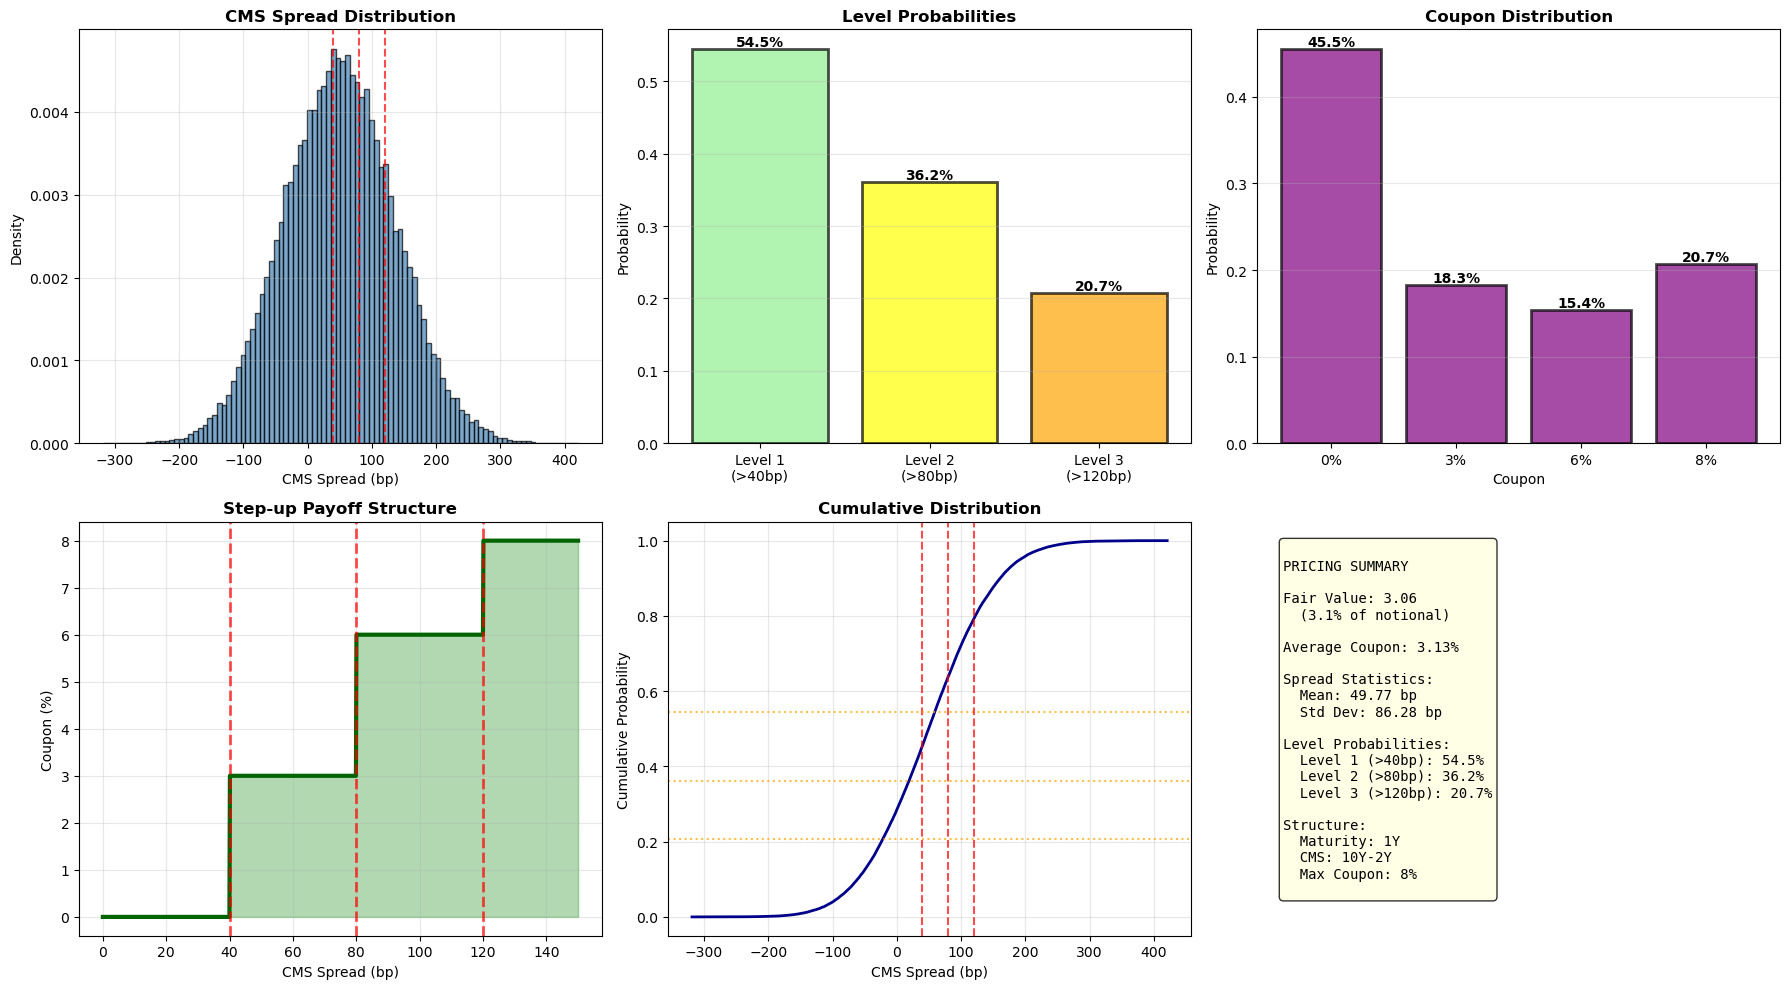


분석 완료!


In [6]:
import numpy as np
from math import exp, log, sqrt
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import csv

DEBUG_MODE = False

# =============================================================================
# 0. SETUP - 시장 데이터 및 파라미터 로드
# =============================================================================
def load_calibrated_params(filename="g2pp_calibrated_params_fast.csv"):
    """보정된 G2++ 파라미터를 CSV에서 로드"""
    params = {}
    try:
        with open(filename, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                if row[0] in ['a', 'b', 'sigma', 'eta', 'rho']:
                    params[row[0]] = float(row[1])
        print(f"✓ 보정된 파라미터를 '{filename}'에서 로드했습니다.")
    except FileNotFoundError:
        print(f"⚠ '{filename}' 파일을 찾을 수 없습니다. 기본값을 사용합니다.")
        params = {
            'a': 0.065776, 'b': 0.484675, 'sigma': 0.014855,
            'eta': 0.016712, 'rho': 0.969087
        }
    return params

PAR_RATES_PCT = {
    1: 3.649, 2: 3.395, 3: 3.335, 5: 3.358, 7: 3.452,
    10: 3.607, 15: 3.810, 30: 3.863,
}

def fill_annual_par_curve_cubic(par_rates_pct):
    known = sorted((int(T), v / 100.0) for T, v in par_rates_pct.items())
    known_T, known_S = [kv[0] for kv in known], [kv[1] for kv in known]
    maxT = known_T[-1]
    spline = CubicSpline(known_T, known_S, bc_type='natural')
    return dict(zip(range(1, maxT + 1), spline(range(1, maxT + 1))))

def make_coupon_times(T, freq):
    delta = 1.0 / freq
    return [i * delta for i in range(1, int(round(T * freq)) + 1)], delta

def get_P_interpolator(P_year):
    known_points = sorted([(0, 1.0)] + list(P_year.items()))
    if len(known_points) < 2:
        return P_year.get
    known_T = [p[0] for p in known_points]
    known_lnP = [log(p[1]) for p in known_points]
    spline = CubicSpline(known_T, known_lnP, bc_type='natural')
    return lambda t: exp(spline(t))

def bootstrap_discounts_from_par(par_rates_dec, freq=1):
    P_year = {}
    for T in sorted(par_rates_dec.keys()):
        S, (coupon_times, delta) = par_rates_dec[T], make_coupon_times(T, freq)
        P_interpolator = get_P_interpolator(P_year)
        known_sum = sum(P_interpolator(ti) for ti in coupon_times[:-1])
        P_T = (1.0 - S * delta * known_sum) / (1.0 + S * delta)
        P_year[T] = P_T
    return P_year

def create_continuous_zero_curve(P_year):
    maturities = np.array([0] + sorted(P_year.keys()))
    dfs = np.array([1.0] + [P_year[t] for t in sorted(P_year.keys())])
    zero_rates = -np.log(dfs) / (maturities + 1e-9)
    zero_rates[0] = zero_rates[1]
    return CubicSpline(maturities, zero_rates, bc_type='natural')

print("=" * 70)
print("CMS 스텝업 스프레드 노트 가격결정 (G2++)")
print("=" * 70)
print("\n[초기화] 시장 곡선 및 파라미터 로드 중...")

par_full = fill_annual_par_curve_cubic(PAR_RATES_PCT)
P_year = bootstrap_discounts_from_par(par_full, freq=1)
continuous_zero_curve = create_continuous_zero_curve(P_year)
P_market_func = lambda t: exp(-continuous_zero_curve(t) * t)

calibrated_params = load_calibrated_params()
print(f"\n사용 중인 G2++ 파라미터:")
for k, v in calibrated_params.items():
    print(f"  {k}: {v:.6f}")

# =============================================================================
# φ(t) 함수 생성
# =============================================================================
def make_lnP_spline(P_year: dict):
    Ts = [0.0] + sorted(float(T) for T in P_year.keys())
    lnPs = [0.0] + [log(P_year[int(T)]) for T in sorted(P_year.keys())]
    spline_lnP = CubicSpline(Ts, lnPs, bc_type="natural")
    spline_dlnP = spline_lnP.derivative()

    def f0(t: float) -> float:
        if t < 1e-9:
            return -float(spline_dlnP(1e-6))
        return -float(spline_dlnP(t))
    return spline_lnP, f0

def phi_g2pp_factory(P_year: dict, a: float, b: float, sigma: float, eta: float, rho: float):
    _, f0 = make_lnP_spline(P_year)

    def phi(t: float) -> float:
        if t < 1e-9:
            t = 1e-9
        ea, eb = exp(-a*t), exp(-b*t)
        term_x = (sigma**2)/(2*a**2) * (1.0 - ea)**2
        term_y = (eta**2)/(2*b**2) * (1.0 - eb)**2
        cross = (rho*sigma*eta)/(a*b) * (1.0 - ea) * (1.0 - eb)
        return f0(t) + term_x + term_y + cross

    return phi, f0

phi_function, f0_function = phi_g2pp_factory(
    P_year,
    calibrated_params['a'], calibrated_params['b'],
    calibrated_params['sigma'], calibrated_params['eta'],
    calibrated_params['rho']
)

# =============================================================================
# G2++ 핵심 함수들
# =============================================================================
def calculate_V(t, T, params):
    a, b, sigma, eta, rho = params['a'], params['b'], params['sigma'], params['eta'], params['rho']
    T_m_t = T - t
    if abs(a) < 1e-9 or abs(b) < 1e-9:
        return 0.0
    term1 = (sigma**2/a**2) * (T_m_t + (2/a)*np.exp(-a*T_m_t) - (1/(2*a))*np.exp(-2*a*T_m_t) - 3/(2*a))
    term2 = (eta**2/b**2) * (T_m_t + (2/b)*np.exp(-b*T_m_t) - (1/(2*b))*np.exp(-2*b*T_m_t) - 3/(2*b))
    term3 = (2*rho*sigma*eta/(a*b)) * (T_m_t + (np.exp(-a*T_m_t)-1)/a + (np.exp(-b*T_m_t)-1)/b - (np.exp(-(a+b)*T_m_t)-1)/(a+b))
    return term1 + term2 + term3

def B(z, t, T):
    if abs(z) < 1e-9:
        return T - t
    return (1 - np.exp(-z * (T - t))) / z

V_0_function = lambda t: calculate_V(0, t, calibrated_params)

# =============================================================================
# 몬테카를로 시뮬레이션
# =============================================================================
def simulate_g2_paths(params, T_expiry, num_paths, num_steps, phi_func):
    """G2++ 경로 시뮬레이션"""
    a, b, sigma, eta, rho = params['a'], params['b'], params['sigma'], params['eta'], params['rho']
    dt = T_expiry / num_steps

    x = np.zeros(num_paths)
    y = np.zeros(num_paths)
    integ_r = np.zeros(num_paths)

    t = 0.0
    for step in range(num_steps):
        if (step + 1) % (num_steps // 10) == 0:
            progress = int((step + 1) / num_steps * 100)
            print(f"  경로 생성: {progress}%", end="\r")

        dw1 = np.random.normal(0, sqrt(dt), num_paths)
        dw2_indep = np.random.normal(0, sqrt(dt), num_paths)
        dw2 = rho * dw1 + sqrt(1 - rho**2) * dw2_indep

        x += -a * x * dt + sigma * dw1
        y += -b * y * dt + eta * dw2

        t += dt
        phi_t = phi_func(t)
        r_t = x + y + phi_t
        integ_r += r_t * dt

    print("  경로 생성: 100% - 완료!")

    D_paths = np.exp(-integ_r)
    return x, y, D_paths

# =============================================================================
# 선도 스왑 금리 계산
# =============================================================================
def calculate_forward_swap_rate(t_future, tenor, x_t, y_t, params, P_market, V_0_func):
    """선도 스왑 금리 계산"""
    a, b = params['a'], params['b']

    swap_start = t_future
    swap_end = t_future + tenor
    payment_times = np.arange(swap_start + 0.5, swap_end + 0.01, 0.5)

    def get_future_P(T_maturity):
        try:
            P_0_T = P_market(T_maturity)
            P_0_t = P_market(t_future)
            V_t_T = calculate_V(t_future, T_maturity, params)
            V_0_T = V_0_func(T_maturity)
            V_0_t = V_0_func(t_future)
            A_t_T = (P_0_T / P_0_t) * exp(0.5 * (V_t_T - V_0_T + V_0_t))
            B_a_t_T = B(a, t_future, T_maturity)
            B_b_t_T = B(b, t_future, T_maturity)
            P_t_T = A_t_T * exp(-B_a_t_T * x_t - B_b_t_T * y_t)
            return P_t_T
        except (OverflowError, ValueError):
            return 0.0

    annuity = sum(0.5 * get_future_P(T_pay) for T_pay in payment_times)
    floating_pv = get_future_P(swap_start) - get_future_P(swap_end)

    if annuity == 0:
        return 0.0

    return floating_pv / annuity


# =============================================================================
# Step-up 페이오프 계산 (NEW)
# =============================================================================
def calculate_stepup_coupon(spread_bp, strikes_bp, step_coupons):
    """
    Step-up 쿠폰 계산

    Args:
        spread_bp: CMS spread (bp)
        strikes_bp: [40, 80, 120] (bp)
        step_coupons: [0.02, 0.02, 0.02] (각 단계별 추가 쿠폰)

    Returns:
        총 쿠폰 (0.00, 0.02, 0.04, 0.06)
    """
    total_coupon = 0.0

    for strike_bp, coupon in zip(strikes_bp, step_coupons):
        if spread_bp > strike_bp:
            total_coupon += coupon

    return total_coupon


# =============================================================================
# 스텝업 CMS 스프레드 노트 가격결정 (MODIFIED)
# =============================================================================
def price_stepup_cms_spread_mcs(params, product_details, P_market, V_0_func,
                                phi_func, num_paths=10000):
    """
    스텝업 CMS 스프레드 노트 가격결정
    """
    T_expiry, tenor_long, tenor_short, strikes_bp, step_coupons, notional = product_details

    print(f"\n[시뮬레이션 시작]")
    print(f"  T={T_expiry}y, CMS={tenor_long}Y-{tenor_short}Y")
    print(f"  Step-up 구조:")
    cumulative_coupon = 0.0
    for i, (strike, coupon) in enumerate(zip(strikes_bp, step_coupons)):
        cumulative_coupon += coupon
        print(f"    Level {i+1}: Spread > {strike}bp → {coupon*100:.0f}% (누적: {cumulative_coupon*100:.0f}%)")
    print(f"  경로 수: {num_paths:,}")

    num_steps = max(int(T_expiry * 252), 100)

    # 경로 생성
    x_T, y_T, D_paths = simulate_g2_paths(params, T_expiry, num_paths, num_steps, phi_func)

    # D_paths 검증
    df_T = P_market(T_expiry)
    mean_D = np.mean(D_paths)
    error_pct = abs(mean_D - df_T) / df_T * 100

    print(f"\n[할인계수 검증]")
    print(f"  E[D_T] = {mean_D:.6f}")
    print(f"  P(0,T) = {df_T:.6f}")
    print(f"  오차: {error_pct:.3f}%")

    if error_pct > 5.0:
        print(f"  ⚠ 경고: 오차가 5%를 초과합니다.")
    elif error_pct > 1.0:
        print(f"  ⚠ 주의: 오차가 1%를 초과합니다.")
    else:
        print(f"  ✓ 검증 통과")

    # 스프레드 계산
    print(f"\n[CMS 스프레드 계산 중...]")
    simulated_spreads = np.zeros(num_paths)

    for i in range(num_paths):
        if (i + 1) % (num_paths // 10) == 0:
            progress = int((i + 1) / num_paths * 100)
            print(f"  진행률: {progress}%", end="\r")

        rate_long = calculate_forward_swap_rate(T_expiry, tenor_long, x_T[i], y_T[i],
                                               params, P_market, V_0_func)
        rate_short = calculate_forward_swap_rate(T_expiry, tenor_short, x_T[i], y_T[i],
                                                params, P_market, V_0_func)
        simulated_spreads[i] = rate_long - rate_short

    print("  진행률: 100% - 완료!")

    # Step-up 페이오프 계산 (MODIFIED)
    payoffs = np.array([
        calculate_stepup_coupon(s * 10000, strikes_bp, step_coupons)
        for s in simulated_spreads
    ])

    # 가격
    price_per_unit = float(np.mean(D_paths * payoffs))
    price = price_per_unit * notional

    # 통계
    spread_mean_bp = np.mean(simulated_spreads) * 10000
    spread_std_bp = np.std(simulated_spreads) * 10000

    # 각 레벨 도달 확률
    level_probs = []
    for strike_bp in strikes_bp:
        prob = np.mean(simulated_spreads * 10000 > strike_bp)
        level_probs.append(prob)

    # 평균 쿠폰
    avg_coupon = np.mean(payoffs)

    stats = {
        "mean_D": mean_D,
        "df_T": df_T,
        "spread_mean_bp": spread_mean_bp,
        "spread_std_bp": spread_std_bp,
        "level_probs": level_probs,
        "avg_coupon": avg_coupon,
        "payoff_distribution": payoffs
    }

    print(f"\n[결과 요약]")
    print(f"  평균 스프레드: {spread_mean_bp:.2f} bp (σ={spread_std_bp:.2f} bp)")
    print(f"  레벨별 도달 확률:")
    for i, (strike, prob) in enumerate(zip(strikes_bp, level_probs)):
        print(f"    Level {i+1} (>{strike}bp): {prob:.2%}")
    print(f"  평균 쿠폰: {avg_coupon*100:.2f}%")

    return price, simulated_spreads, D_paths, payoffs, stats


# =============================================================================
# 실행
# =============================================================================
if __name__ == "__main__":
    # 상품 스펙 (MODIFIED)
    product = {
        'expiry': 1,
        'tenor_long': 10.0,
        'tenor_short': 2.0,
        'strikes_bp': [40, 80, 120],      # Step-up strikes (bp)
        'step_coupons': [0.03, 0.03, 0.02],  # 각 레벨별 추가 쿠폰
        'notional': 100
    }

    print("\n" + "=" * 70)
    print("상품 스펙 - Step-up CMS Spread Note")
    print("=" * 70)
    print(f"만기: {product['expiry']}년")
    print(f"CMS: {product['tenor_long']:.0f}Y - {product['tenor_short']:.0f}Y")
    print(f"Step-up 구조:")
    cumulative = 0.0
    for i, (strike, coupon) in enumerate(zip(product['strikes_bp'], product['step_coupons'])):
        cumulative += coupon
        print(f"  Level {i+1}: Spread > {strike}bp → +{coupon*100:.0f}% (누적 {cumulative*100:.0f}%)")
    print(f"Notional: {product['notional']}")

    # 가격 계산
    final_price, spreads, D_paths, payoffs, stats = price_stepup_cms_spread_mcs(
        calibrated_params,
        (product['expiry'], product['tenor_long'], product['tenor_short'],
         product['strikes_bp'], product['step_coupons'], product['notional']),
        P_market_func,
        V_0_function,
        phi_func=phi_function,
        num_paths=50000
    )

    # 최종 결과
    print("\n" + "=" * 70)
    print("최종 가격")
    print("=" * 70)
    print(f"현재가치: {final_price:.2f}")
    print(f"액면가 대비: {final_price/product['notional']*100:.2f}%")
    print(f"평균 쿠폰: {stats['avg_coupon']*100:.2f}%")

    # 시각화
    print("\n[그래프 생성 중...]")
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1) CMS 스프레드 분포
    ax1 = axes[0, 0]
    ax1.hist(spreads * 10000, bins=100, density=True, alpha=0.7,
             color='steelblue', edgecolor='black')
    for strike in product['strikes_bp']:
        ax1.axvline(strike, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.set_title(f"CMS Spread Distribution", fontsize=12, fontweight='bold')
    ax1.set_xlabel("CMS Spread (bp)")
    ax1.set_ylabel("Density")
    ax1.grid(True, alpha=0.3)

    # 2) 레벨별 도달 확률
    ax2 = axes[0, 1]
    levels = [f"Level {i+1}\n(>{s}bp)" for i, s in enumerate(product['strikes_bp'])]
    probs = stats['level_probs']
    colors = ['lightgreen', 'yellow', 'orange']
    bars = ax2.bar(levels, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

    ax2.set_title("Level Probabilities", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Probability")
    ax2.grid(True, alpha=0.3, axis='y')

    # 3) 쿠폰 분포
    ax3 = axes[0, 2]
    unique_coupons = sorted(set(payoffs))
    coupon_counts = [np.sum(payoffs == c) for c in unique_coupons]
    coupon_probs = [count / len(payoffs) for count in coupon_counts]

    bars3 = ax3.bar([f"{c*100:.0f}%" for c in unique_coupons], coupon_probs,
                    color='purple', alpha=0.7, edgecolor='black', linewidth=2)

    for bar, prob in zip(bars3, coupon_probs):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

    ax3.set_title("Coupon Distribution", fontsize=12, fontweight='bold')
    ax3.set_xlabel("Coupon")
    ax3.set_ylabel("Probability")
    ax3.grid(True, alpha=0.3, axis='y')

    # 4) Step-up 페이오프 구조
    ax4 = axes[1, 0]
    spread_range = np.linspace(0, 150, 1000)
    payoff_range = [calculate_stepup_coupon(s, product['strikes_bp'],
                                            product['step_coupons']) * 100
                   for s in spread_range]

    ax4.plot(spread_range, payoff_range, linewidth=3, color='darkgreen')
    ax4.fill_between(spread_range, 0, payoff_range, alpha=0.3, color='green')

    for strike in product['strikes_bp']:
        ax4.axvline(strike, color='red', linestyle='--', linewidth=2, alpha=0.7)

    ax4.set_title("Step-up Payoff Structure", fontsize=12, fontweight='bold')
    ax4.set_xlabel("CMS Spread (bp)")
    ax4.set_ylabel("Coupon (%)")
    ax4.grid(True, alpha=0.3)

    # 5) 누적 분포 함수 (CDF)
    ax5 = axes[1, 1]
    sorted_spreads = np.sort(spreads * 10000)
    cumulative = np.arange(1, len(sorted_spreads) + 1) / len(sorted_spreads)
    ax5.plot(sorted_spreads, cumulative, linewidth=2, color='darkblue')

    for i, strike in enumerate(product['strikes_bp']):
        ax5.axvline(strike, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax5.axhline(stats['level_probs'][i], color='orange', linestyle=':',
                   linewidth=1.5, alpha=0.7)

    ax5.set_title("Cumulative Distribution", fontsize=12, fontweight='bold')
    ax5.set_xlabel("CMS Spread (bp)")
    ax5.set_ylabel("Cumulative Probability")
    ax5.grid(True, alpha=0.3)

    # 6) 요약 통계
    ax6 = axes[1, 2]
    ax6.axis('off')

    summary_text = f"""
PRICING SUMMARY

Fair Value: {final_price:.2f}
  ({final_price/product['notional']*100:.1f}% of notional)

Average Coupon: {stats['avg_coupon']*100:.2f}%

Spread Statistics:
  Mean: {stats['spread_mean_bp']:.2f} bp
  Std Dev: {stats['spread_std_bp']:.2f} bp

Level Probabilities:
  Level 1 (>{product['strikes_bp'][0]}bp): {stats['level_probs'][0]:.1%}
  Level 2 (>{product['strikes_bp'][1]}bp): {stats['level_probs'][1]:.1%}
  Level 3 (>{product['strikes_bp'][2]}bp): {stats['level_probs'][2]:.1%}

Structure:
  Maturity: {product['expiry']}Y
  CMS: {product['tenor_long']:.0f}Y-{product['tenor_short']:.0f}Y
  Max Coupon: {sum(product['step_coupons'])*100:.0f}%
"""

    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=10, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

    plt.tight_layout()
    plt.savefig('cms_stepup_note_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ 그래프 저장 완료: cms_stepup_note_analysis.png")
    plt.show()

    print("\n" + "=" * 70)
    print("분석 완료!")
    print("=" * 70)

# 델타 & 감마 동적 헷징


CMS Step-up: 델타 + 감마 동적 헤징 분석

상품 정보:
  만기: 1Y
  CMS: 10Y - 2Y
  Strikes: [40, 80, 120]bp
  Notional: 100

헤징 정책:
  델타 헤징:
    - 주기: 5영업일 (주간)
    - 비용: 1.5bp/거래
  감마 헤징:
    - Zone width: ±7.0bp
    - 비용: 2.0bp/거래
    - 리밸런싱: 델타 변화 30.0% 이상
    - 최소 간격: 3영업일

[G2++ 시뮬레이션]
  전체 경로 생성 중... (paths=10000, steps=252)
    100% 완료!

델타 + 감마 동적 헤징 시뮬레이션

헤징 정책:
  델타 헤징: 5일마다 (주간)
  감마 헤징:
    - Zone 진입/이탈: 즉시
    - Zone 내부: 델타 변화 30.0% 이상
    - 최소 간격: 3일

DV01 추정:
  10Y CMS: 1667.1466
  2Y CMS: 382.6282

Zone 정의 (width = ±7.0bp):
  Zone 1: [33bp, 47bp] (중심: 40bp)
  Zone 2: [73bp, 87bp] (중심: 80bp)
  Zone 3: [113bp, 127bp] (중심: 120bp)

경로 분석 중... (총 10,000개 경로)
  진행률: 100% 완료!

헤징 결과

델타 헤징 (주간):
  평균 거래 횟수: 51.00회/년
  평균 비용: 15.680777 (1568.078bp)

감마 헤징 (조건부):
  평균 거래 횟수: 21.46회/년
  평균 비용: 8.798699 (879.870bp)

총 헤징 비용:
  평균: 0.648746 (64.875bp)
  중앙값: 0.673497 (67.350bp)
  95% 백분위: 1.244506 (124.451bp)

[시각화 생성 중...]


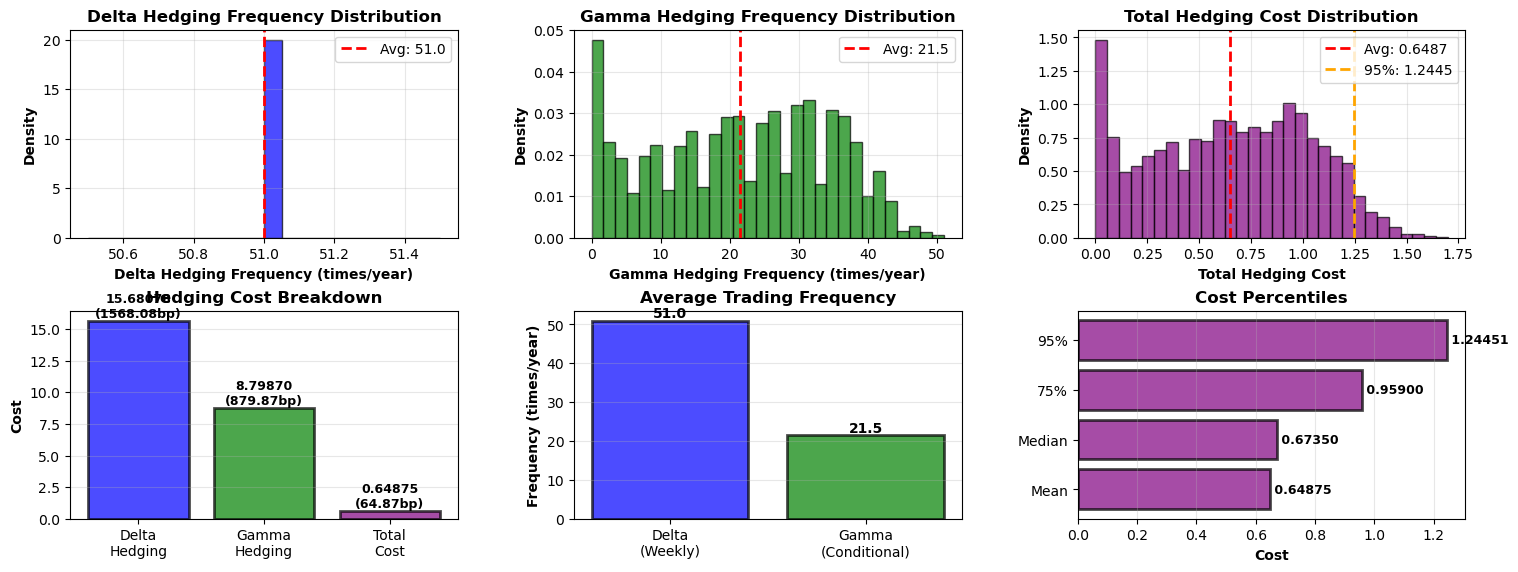


분석 완료!

최종 권장사항:
  • 델타 헤징: 주간 리밸런싱 (51회/년)
  • 감마 헤징: 조건부 (21회/년)
  • 평균 총 비용: 0.648746 (64.875bp)
  • 가격 반영: 1.244506 (124.451bp) 사용 권장

민감도 분석 제안:
  • Zone width 변경: 5bp → 3bp, 7bp, 10bp
  • 델타 주기 변경: 5일 → 3일, 7일, 10일
  • 감마 임계값 변경: 30% → 20%, 40%, 50%
  • 최소 간격 변경: 3일 → 1일, 5일, 7일


In [9]:
import numpy as np
from math import exp, log, sqrt
from scipy.interpolate import CubicSpline
import matplotlib
import matplotlib.pyplot as plt
import csv
import platform

# Matplotlib의 모든 설정을 기본값으로 초기화하여 외부 설정의 영향을 받지 않도록 합니다.
# 이 코드가 'NanumGothic' not found 경고를 원천적으로 방지합니다.
matplotlib.rcdefaults()

# =============================================================================
# SETUP (이전 코드와 동일)
# =============================================================================
def load_calibrated_params(filename="g2pp_calibrated_params_fast.csv"):
    params = {}
    try:
        with open(filename, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                if row[0] in ['a', 'b', 'sigma', 'eta', 'rho']:
                    params[row[0]] = float(row[1])
    except FileNotFoundError:
        params = {'a': 0.024749, 'b': 0.461650, 'sigma': 0.010600,
                  'eta': 0.023271, 'rho': 0.624061}
    return params

PAR_RATES_PCT = {1: 3.649, 2: 3.395, 3: 3.335, 5: 3.358, 7: 3.452,
                 10: 3.607, 15: 3.810, 30: 3.863}

def fill_annual_par_curve_cubic(par_rates_pct):
    known = sorted((int(T), v / 100.0) for T, v in par_rates_pct.items())
    known_T, known_S = [kv[0] for kv in known], [kv[1] for kv in known]
    maxT = known_T[-1]
    spline = CubicSpline(known_T, known_S, bc_type='natural')
    return dict(zip(range(1, maxT + 1), spline(range(1, maxT + 1))))

def make_coupon_times(T, freq):
    delta = 1.0 / freq
    return [i * delta for i in range(1, int(round(T * freq)) + 1)], delta

def get_P_interpolator(P_year):
    known_points = sorted([(0, 1.0)] + list(P_year.items()))
    if len(known_points) < 2:
        return P_year.get
    known_T = [p[0] for p in known_points]
    known_lnP = [log(p[1]) for p in known_points]
    spline = CubicSpline(known_T, known_lnP, bc_type='natural')
    return lambda t: exp(spline(t))

def bootstrap_discounts_from_par(par_rates_dec, freq=1):
    P_year = {}
    for T in sorted(par_rates_dec.keys()):
        S, (coupon_times, delta) = par_rates_dec[T], make_coupon_times(T, freq)
        P_interpolator = get_P_interpolator(P_year)
        known_sum = sum(P_interpolator(ti) for ti in coupon_times[:-1])
        P_T = (1.0 - S * delta * known_sum) / (1.0 + S * delta)
        P_year[T] = P_T
    return P_year

def create_continuous_zero_curve(P_year):
    maturities = np.array([0] + sorted(P_year.keys()))
    dfs = np.array([1.0] + [P_year[t] for t in sorted(P_year.keys())])
    zero_rates = -np.log(dfs) / (maturities + 1e-9)
    zero_rates[0] = zero_rates[1]
    return CubicSpline(maturities, zero_rates, bc_type='natural')

def make_lnP_spline(P_year):
    Ts = [0.0] + sorted(float(T) for T in P_year.keys())
    lnPs = [0.0] + [log(P_year[int(T)]) for T in sorted(P_year.keys())]
    spline_lnP = CubicSpline(Ts, lnPs, bc_type="natural")
    spline_dlnP = spline_lnP.derivative()
    def f0(t):
        if t < 1e-9:
            return -float(spline_dlnP(1e-6))
        return -float(spline_dlnP(t))
    return spline_lnP, f0

def phi_g2pp_factory(P_year, a, b, sigma, eta, rho):
    _, f0 = make_lnP_spline(P_year)
    def phi(t):
        if t < 1e-9:
            t = 1e-9
        ea, eb = exp(-a*t), exp(-b*t)
        term_x = (sigma**2)/(2*a**2) * (1.0 - ea)**2
        term_y = (eta**2)/(2*b**2) * (1.0 - eb)**2
        cross = (rho*sigma*eta)/(a*b) * (1.0 - ea) * (1.0 - eb)
        return f0(t) + term_x + term_y + cross
    return phi, f0

def calculate_V(t, T, params):
    a, b, sigma, eta, rho = params['a'], params['b'], params['sigma'], params['eta'], params['rho']
    T_m_t = T - t
    if abs(a) < 1e-9 or abs(b) < 1e-9:
        return 0.0
    term1 = (sigma**2/a**2) * (T_m_t + (2/a)*np.exp(-a*T_m_t) - (1/(2*a))*np.exp(-2*a*T_m_t) - 3/(2*a))
    term2 = (eta**2/b**2) * (T_m_t + (2/b)*np.exp(-b*T_m_t) - (1/(2*b))*np.exp(-2*b*T_m_t) - 3/(2*b))
    term3 = (2*rho*sigma*eta/(a*b)) * (T_m_t + (np.exp(-a*T_m_t)-1)/a + (np.exp(-b*T_m_t)-1)/b - (np.exp(-(a+b)*T_m_t)-1)/(a+b))
    return term1 + term2 + term3

def B(z, t, T):
    if abs(z) < 1e-9:
        return T - t
    return (1 - np.exp(-z * (T - t))) / z

def calculate_forward_swap_rate(t_future, tenor, x_t, y_t, params, P_market, V_0_func):
    a, b = params['a'], params['b']
    swap_start = t_future
    swap_end = t_future + tenor
    payment_times = np.arange(swap_start + 0.5, swap_end + 0.01, 0.5)
    
    def get_future_P(T_maturity):
        try:
            P_0_T = P_market(T_maturity)
            P_0_t = P_market(t_future)
            V_t_T = calculate_V(t_future, T_maturity, params)
            V_0_T = V_0_func(T_maturity)
            V_0_t = V_0_func(t_future)
            A_t_T = (P_0_T / P_0_t) * exp(0.5 * (V_t_T - V_0_T + V_0_t))
            B_a_t_T = B(a, t_future, T_maturity)
            B_b_t_T = B(b, t_future, T_maturity)
            P_t_T = A_t_T * exp(-B_a_t_T * x_t - B_b_t_T * y_t)
            return P_t_T
        except:
            return 0.0
    
    annuity = sum(0.5 * get_future_P(T_pay) for T_pay in payment_times)
    floating_pv = get_future_P(swap_start) - get_future_P(swap_end)
    if annuity == 0:
        return 0.0
    return floating_pv / annuity

# =============================================================================
# 델타 계산 함수
# =============================================================================
def calculate_delta_at_point(spread_bp, strikes_bp, step_coupons, band_bp, notional):
    """
    특정 스프레드에서의 Step-up Delta 계산
    
    Delta = ∂(Payoff) / ∂(Spread)
    """
    total_delta = 0.0
    
    for strike, coupon in zip(strikes_bp, step_coupons):
        # Strike 근처에서만 델타가 존재
        distance = abs(spread_bp - strike)
        
        if distance < band_bp:
            # Zone 내부: 델타가 선형적으로 변화
            # 최대 델타 = coupon * notional / (2 * band_bp)
            max_delta = (coupon * notional) / (2 * band_bp)
            
            # Strike 위/아래에 따라 부호 결정
            if spread_bp > strike:
                # Strike 위: 양의 델타 (spread 증가 시 payoff 증가)
                delta_contribution = max_delta * (1 - distance / band_bp)
            else:
                # Strike 아래: 음의 델타
                delta_contribution = -max_delta * (1 - distance / band_bp)
            
            total_delta += delta_contribution
    
    return total_delta

# =============================================================================
# DV01 추정 함수
# =============================================================================
def estimate_cms_dv01(tenor, notional_unit=1_000_000, current_rate=0.036):
    """CMS Swap DV01 추정 (간단한 근사)"""
    n = tenor * 2  # 반년 단위
    r = current_rate / 2
    
    if r < 1e-9:
        mod_duration = n
    else:
        mod_duration = (1 - (1 + r)**(-n)) / r
    
    dv01 = mod_duration * notional_unit * 0.0001
    return dv01

def simulate_g2_paths_full_trajectory(params, T_expiry, num_paths, num_steps, phi_func, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    print(f"  전체 경로 생성 중... (paths={num_paths}, steps={num_steps})")
    
    a, b, sigma, eta, rho = params['a'], params['b'], params['sigma'], params['eta'], params['rho']
    dt = T_expiry / num_steps
    
    x_paths = np.zeros((num_paths, num_steps + 1))
    y_paths = np.zeros((num_paths, num_steps + 1))
    integ_r = np.zeros(num_paths)
    
    for step in range(num_steps):
        if (step + 1) % (num_steps // 10) == 0:
            print(f"    {(step+1)/num_steps*100:.0f}%", end='\r')
        
        dw1 = np.random.normal(0, sqrt(dt), num_paths)
        dw2_indep = np.random.normal(0, sqrt(dt), num_paths)
        dw2 = rho * dw1 + sqrt(1 - rho**2) * dw2_indep
        
        x_paths[:, step+1] = x_paths[:, step] - a * x_paths[:, step] * dt + sigma * dw1
        y_paths[:, step+1] = y_paths[:, step] - b * y_paths[:, step] * dt + eta * dw2
        
        t = (step + 1) * dt
        phi_t = phi_func(t)
        r_t = x_paths[:, step+1] + y_paths[:, step+1] + phi_t
        integ_r += r_t * dt
    
    print("    100% 완료!")
    
    D_paths = np.exp(-integ_r)
    return x_paths, y_paths, D_paths

def calculate_stepup_coupon(spread_bp, strikes_bp, step_coupons):
    """Step-up 쿠폰 계산"""
    total_coupon = 0.0
    for strike_bp, coupon in zip(strikes_bp, step_coupons):
        if spread_bp > strike_bp:
            total_coupon += coupon
    return total_coupon

# =============================================================================
# 델타 + 감마 동적 헤징 시뮬레이션
# =============================================================================
def simulate_dynamic_hedging(x_paths, y_paths, params, product, hedging_policy, 
                             P_market, V_0_func):
    """
    델타 + 감마 동적 헤징 시뮬레이션
    
    델타 헤징: 주간 (매주 금요일)
    감마 헤징: 조건부
      1. Zone 진입/이탈 시 즉시
      2. Zone 내에서 델타 변화 30% 이상 시
      3. 최소 3일 간격
    """
    print(f"\n{'='*70}")
    print(f"델타 + 감마 동적 헤징 시뮬레이션")
    print(f"{'='*70}")
    
    num_paths, num_steps_plus_one = x_paths.shape
    num_steps = num_steps_plus_one - 1
    T_expiry = product['expiry']
    dt = T_expiry / num_steps
    
    # 거래일 기준 (1년 = 252일)
    trading_days_per_year = 252
    dt_days = T_expiry * trading_days_per_year / num_steps
    
    notional = product['notional']
    strikes_bp = product['strikes_bp']
    band_bp = hedging_policy['band_bp']
    
    # 거래 비용 (bid-ask spread)
    delta_cost_per_trade_bp = hedging_policy['delta_cost_bp']
    gamma_cost_per_trade_bp = hedging_policy['gamma_cost_bp']
    
    # 헤징 주기
    delta_rehedge_days = hedging_policy['delta_rehedge_days']  # 5 영업일 (1주)
    gamma_min_days = hedging_policy['gamma_min_days']  # 3 영업일
    gamma_delta_threshold = hedging_policy['gamma_delta_threshold']  # 30%
    
    # DV01 추정 (10Y와 2Y CMS)
    dv01_10y = estimate_cms_dv01(product['tenor_long'], notional_unit=1_000_000, current_rate=0.036)
    dv01_2y = estimate_cms_dv01(product['tenor_short'], notional_unit=1_000_000, current_rate=0.036)
    
    # Zone 정의
    zones = []
    for strike in strikes_bp:
        zones.append({
            'strike': strike,
            'lower': strike - band_bp,
            'upper': strike + band_bp
        })
    
    print(f"\n헤징 정책:")
    print(f"  델타 헤징: {delta_rehedge_days}일마다 (주간)")
    print(f"  감마 헤징:")
    print(f"    - Zone 진입/이탈: 즉시")
    print(f"    - Zone 내부: 델타 변화 {gamma_delta_threshold}% 이상")
    print(f"    - 최소 간격: {gamma_min_days}일")
    
    print(f"\nDV01 추정:")
    print(f"  10Y CMS: {dv01_10y:.4f}")
    print(f"  2Y CMS: {dv01_2y:.4f}")
    
    print(f"\nZone 정의 (width = ±{band_bp}bp):")
    for i, zone in enumerate(zones):
        print(f"  Zone {i+1}: [{zone['lower']:.0f}bp, {zone['upper']:.0f}bp] (중심: {zone['strike']}bp)")
    
    print(f"\n경로 분석 중... (총 {num_paths:,}개 경로)")
    
    # 샘플링 (속도를 위해)
    sample_size = min(num_paths, 5000)
    sample_indices = np.random.choice(num_paths, sample_size, replace=False)
    
    # 결과 저장
    delta_trades_per_path = []
    gamma_trades_per_path = []
    total_costs_per_path = []
    
    for idx, path_idx in enumerate(sample_indices):
        if (idx + 1) % (sample_size // 10) == 0:
            print(f"  진행률: {(idx+1)/sample_size*100:.0f}%", end='\r')
        
        delta_trades = 0
        gamma_trades = 0
        delta_cost_accumulated = 0.0
        gamma_cost_accumulated = 0.0
        
        # 델타 추적
        last_delta_hedge_day = -999  # 마지막 델타 헤징 날짜
        last_hedged_delta = 0.0  # 마지막으로 헤징한 델타 값
        
        # 감마 추적 (Zone별)
        in_zone_prev = [False] * len(zones)
        last_gamma_hedge_day = [-999] * len(zones)
        last_delta_in_zone = [0.0] * len(zones)
        
        for step in range(num_steps + 1):
            t = step * dt
            current_day = step * dt_days
            
            x_t = x_paths[path_idx, step]
            y_t = y_paths[path_idx, step]
            
            # 스프레드 계산
            rate_10y = calculate_forward_swap_rate(
                t, product['tenor_long'], x_t, y_t, params, P_market, V_0_func
            )
            rate_2y = calculate_forward_swap_rate(
                t, product['tenor_short'], x_t, y_t, params, P_market, V_0_func
            )
            spread_bp = (rate_10y - rate_2y) * 10000
            
            # 현재 델타 계산 (간단한 근사)
            current_delta = 0.0
            for zone in zones:
                if abs(spread_bp - zone['strike']) < band_bp:
                    # Zone 근처에 있으면 델타 기여
                    coupon_diff = 0.01  # 1% 쿠폰 차이
                    current_delta += coupon_diff * notional / (2 * band_bp)
            
            # === 델타 헤징 ===
            if current_day - last_delta_hedge_day >= delta_rehedge_days:
                delta_trades += 1
                
                # 델타 변화량
                delta_change = abs(current_delta - last_hedged_delta)
                
                # 헤징 규모 = 델타 변화량
                # CMS swap으로 헤징
                hedge_notional = delta_change * (notional / 100) * 1_000_000
                
                # 비용 = 헤징 규모 × DV01 × bid-ask
                # 스프레드 헤징이므로 10Y와 2Y 모두 고려
                cost_10y = (hedge_notional / 1_000_000) * dv01_10y * (delta_cost_per_trade_bp / 10000)
                cost_2y = (hedge_notional / 1_000_000) * dv01_2y * (delta_cost_per_trade_bp / 10000)
                delta_cost_accumulated += (cost_10y + cost_2y)
                
                last_delta_hedge_day = current_day
                last_hedged_delta = current_delta
            
            # === 감마 헤징 ===
            for zone_idx, zone in enumerate(zones):
                in_zone_now = (zone['lower'] <= spread_bp <= zone['upper'])
                days_since_last_gamma = current_day - last_gamma_hedge_day[zone_idx]
                
                # 1) Zone 진입/이탈
                if in_zone_now != in_zone_prev[zone_idx]:
                    if days_since_last_gamma >= gamma_min_days:
                        gamma_trades += 1
                        
                        # 델타 변화량
                        delta_change = abs(current_delta - last_delta_in_zone[zone_idx])
                        
                        # 포지션 변화량에 비례한 비용
                        hedge_notional = delta_change * (notional / 100) * 1_000_000
                        
                        cost_10y = (hedge_notional / 1_000_000) * dv01_10y * (gamma_cost_per_trade_bp / 10000)
                        cost_2y = (hedge_notional / 1_000_000) * dv01_2y * (gamma_cost_per_trade_bp / 10000)
                        gamma_cost_accumulated += (cost_10y + cost_2y)
                        
                        last_gamma_hedge_day[zone_idx] = current_day
                        last_delta_in_zone[zone_idx] = current_delta
                
                # 2) Zone 내부 리밸런싱
                elif in_zone_now:
                    if last_delta_in_zone[zone_idx] > 0:
                        delta_change_pct = abs(current_delta - last_delta_in_zone[zone_idx]) / last_delta_in_zone[zone_idx] * 100
                        
                        if delta_change_pct > gamma_delta_threshold and days_since_last_gamma >= gamma_min_days:
                            gamma_trades += 1
                            
                            # 델타 변화량
                            delta_change = abs(current_delta - last_delta_in_zone[zone_idx])
                            
                            # 포지션 변화량에 비례한 비용
                            hedge_notional = delta_change * (notional / 100) * 1_000_000
                            
                            cost_10y = (hedge_notional / 1_000_000) * dv01_10y * (gamma_cost_per_trade_bp / 10000)
                            cost_2y = (hedge_notional / 1_000_000) * dv01_2y * (gamma_cost_per_trade_bp / 10000)
                            gamma_cost_accumulated += (cost_10y + cost_2y)
                            
                            last_gamma_hedge_day[zone_idx] = current_day
                            last_delta_in_zone[zone_idx] = current_delta
                
                in_zone_prev[zone_idx] = in_zone_now
        
        # 총 비용
        total_cost = delta_cost_accumulated + gamma_cost_accumulated
        
        delta_trades_per_path.append(delta_trades)
        gamma_trades_per_path.append(gamma_trades)
        total_costs_per_path.append(total_cost)
    
    print("  진행률: 100% 완료!")
    
    # 통계 계산
    delta_trades_array = np.array(delta_trades_per_path)
    gamma_trades_array = np.array(gamma_trades_per_path)
    total_costs_array = np.array(total_costs_per_path)
    
    # 평균 비용 재계산 (경로별 실제 비용 사용)
    avg_delta_cost = np.mean([
        delta_trades_per_path[i] * (notional / 100) * 1_000_000 / 1_000_000 * 
        (dv01_10y + dv01_2y) * (delta_cost_per_trade_bp / 10000)
        for i in range(len(delta_trades_per_path))
    ])
    
    avg_gamma_cost = np.mean([
        gamma_trades_per_path[i] * (notional / 100) * 1_000_000 / 1_000_000 * 
        (dv01_10y + dv01_2y) * (gamma_cost_per_trade_bp / 10000)
        for i in range(len(gamma_trades_per_path))
    ])
    
    results = {
        'delta': {
            'avg_trades': np.mean(delta_trades_array),
            'median_trades': np.median(delta_trades_array),
            'std_trades': np.std(delta_trades_array),
            'avg_cost': avg_delta_cost,
        },
        'gamma': {
            'avg_trades': np.mean(gamma_trades_array),
            'median_trades': np.median(gamma_trades_array),
            'std_trades': np.std(gamma_trades_array),
            'avg_cost': avg_gamma_cost,
        },
        'total': {
            'avg_cost': np.mean(total_costs_array),
            'median_cost': np.median(total_costs_array),
            'std_cost': np.std(total_costs_array),
            'percentile_95': np.percentile(total_costs_array, 95),
        },
        'distributions': {
            'delta_trades': delta_trades_array,
            'gamma_trades': gamma_trades_array,
            'total_costs': total_costs_array,
        }
    }
    
    # 결과 출력
    print(f"\n{'='*70}")
    print(f"헤징 결과")
    print(f"{'='*70}")
    
    print(f"\n델타 헤징 (주간):")
    print(f"  평균 거래 횟수: {results['delta']['avg_trades']:.2f}회/년")
    print(f"  평균 비용: {results['delta']['avg_cost']:.6f} ({results['delta']['avg_cost']/notional*10000:.3f}bp)")
    
    print(f"\n감마 헤징 (조건부):")
    print(f"  평균 거래 횟수: {results['gamma']['avg_trades']:.2f}회/년")
    print(f"  평균 비용: {results['gamma']['avg_cost']:.6f} ({results['gamma']['avg_cost']/notional*10000:.3f}bp)")
    
    print(f"\n총 헤징 비용:")
    print(f"  평균: {results['total']['avg_cost']:.6f} ({results['total']['avg_cost']/notional*10000:.3f}bp)")
    print(f"  중앙값: {results['total']['median_cost']:.6f} ({results['total']['median_cost']/notional*10000:.3f}bp)")
    print(f"  95% 백분위: {results['total']['percentile_95']:.6f} ({results['total']['percentile_95']/notional*10000:.3f}bp)")
    
    return results

# =============================================================================
# 시각화 함수
# =============================================================================
def plot_dynamic_hedging_results(results, product, hedging_policy):
    """동적 헤징 결과 시각화 (영문)"""
    
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    
    notional = product['notional']
    
    # 1) Delta trades distribution
    ax1 = fig.add_subplot(gs[0, 0])
    delta_trades = results['distributions']['delta_trades']
    
    ax1.hist(delta_trades, bins=20, density=True, alpha=0.7,
             color='blue', edgecolor='black')
    ax1.axvline(results['delta']['avg_trades'], color='red', linestyle='--',
               linewidth=2, label=f"Avg: {results['delta']['avg_trades']:.1f}")
    
    ax1.set_xlabel('Delta Hedging Frequency (times/year)', fontweight='bold')
    ax1.set_ylabel('Density', fontweight='bold')
    ax1.set_title('Delta Hedging Frequency Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2) Gamma trades distribution
    ax2 = fig.add_subplot(gs[0, 1])
    gamma_trades = results['distributions']['gamma_trades']
    
    ax2.hist(gamma_trades, bins=30, density=True, alpha=0.7,
             color='green', edgecolor='black')
    ax2.axvline(results['gamma']['avg_trades'], color='red', linestyle='--',
               linewidth=2, label=f"Avg: {results['gamma']['avg_trades']:.1f}")
    
    ax2.set_xlabel('Gamma Hedging Frequency (times/year)', fontweight='bold')
    ax2.set_ylabel('Density', fontweight='bold')
    ax2.set_title('Gamma Hedging Frequency Distribution', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3) Total cost distribution
    ax3 = fig.add_subplot(gs[0, 2])
    total_costs = results['distributions']['total_costs']
    
    ax3.hist(total_costs, bins=30, density=True, alpha=0.7,
             color='purple', edgecolor='black')
    ax3.axvline(results['total']['avg_cost'], color='red', linestyle='--',
               linewidth=2, label=f"Avg: {results['total']['avg_cost']:.4f}")
    ax3.axvline(results['total']['percentile_95'], color='orange', linestyle='--',
               linewidth=2, label=f"95%: {results['total']['percentile_95']:.4f}")
    
    ax3.set_xlabel('Total Hedging Cost', fontweight='bold')
    ax3.set_ylabel('Density', fontweight='bold')
    ax3.set_title('Total Hedging Cost Distribution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4) Cost breakdown
    ax4 = fig.add_subplot(gs[1, 0])
    
    components = ['Delta\nHedging', 'Gamma\nHedging', 'Total\nCost']
    costs = [
        results['delta']['avg_cost'],
        results['gamma']['avg_cost'],
        results['total']['avg_cost']
    ]
    colors = ['blue', 'green', 'purple']
    
    bars = ax4.bar(components, costs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, cost in zip(bars, costs):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{cost:.5f}\n({cost/notional*10000:.2f}bp)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.set_ylabel('Cost', fontweight='bold')
    ax4.set_title('Hedging Cost Breakdown', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5) Trade frequency comparison
    ax5 = fig.add_subplot(gs[1, 1])
    
    types = ['Delta\n(Weekly)', 'Gamma\n(Conditional)']
    trades = [
        results['delta']['avg_trades'],
        results['gamma']['avg_trades']
    ]
    colors = ['blue', 'green']
    
    bars = ax5.bar(types, trades, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, trade in zip(bars, trades):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{trade:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax5.set_ylabel('Frequency (times/year)', fontweight='bold')
    ax5.set_title('Average Trading Frequency', fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # 6) Cost percentiles
    ax6 = fig.add_subplot(gs[1, 2])
    
    percentiles = ['Mean', 'Median', '75%', '95%']
    cost_values = [
        results['total']['avg_cost'],
        results['total']['median_cost'],
        np.percentile(total_costs, 75),
        results['total']['percentile_95']
    ]
    
    bars = ax6.barh(percentiles, cost_values, color='purple', alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, cost in zip(bars, cost_values):
        ax6.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f' {cost:.5f}', va='center', fontweight='bold', fontsize=9)
    
    ax6.set_xlabel('Cost', fontweight='bold')
    ax6.set_title('Cost Percentiles', fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


# =============================================================================
# 메인 실행
# =============================================================================
if __name__ == "__main__":
    print("\n" + "="*70)
    print("CMS Step-up: 델타 + 감마 동적 헤징 분석")
    print("="*70)
    
    # 1. 파라미터 로드
    calibrated_params = load_calibrated_params()
    
    product = {
        'expiry': 1,
        'tenor_long': 10.0,
        'tenor_short': 2.0,
        'strikes_bp': [40, 80, 120],
        'step_coupons': [0.03, 0.03, 0.02],
        'notional': 100
    }
    
    hedging_policy = {
        # Delta 헤징
        'delta_rehedge_days': 5,  # 주간 (매주 금요일)
        'delta_cost_bp': 1.5,     # 델타 헤징은 스프레드가 작음
        
        # Gamma 헤징
        'band_bp': 7.0,           # Zone width
        'gamma_cost_bp': 2.0,     # 감마 헤징은 스프레드가 약간 큼
        'gamma_min_days': 3,      # 최소 3영업일 간격
        'gamma_delta_threshold': 30.0,  # 델타 변화 30% 이상
        
        # 시뮬레이션
        'num_sim_paths': 10000
    }
    
    print(f"\n상품 정보:")
    print(f"  만기: {product['expiry']}Y")
    print(f"  CMS: {product['tenor_long']:.0f}Y - {product['tenor_short']:.0f}Y")
    print(f"  Strikes: {product['strikes_bp']}bp")
    print(f"  Notional: {product['notional']}")
    
    print(f"\n헤징 정책:")
    print(f"  델타 헤징:")
    print(f"    - 주기: {hedging_policy['delta_rehedge_days']}영업일 (주간)")
    print(f"    - 비용: {hedging_policy['delta_cost_bp']}bp/거래")
    print(f"  감마 헤징:")
    print(f"    - Zone width: ±{hedging_policy['band_bp']}bp")
    print(f"    - 비용: {hedging_policy['gamma_cost_bp']}bp/거래")
    print(f"    - 리밸런싱: 델타 변화 {hedging_policy['gamma_delta_threshold']}% 이상")
    print(f"    - 최소 간격: {hedging_policy['gamma_min_days']}영업일")
    
    # 2. 시장 데이터 준비
    par_full = fill_annual_par_curve_cubic(PAR_RATES_PCT)
    P_year = bootstrap_discounts_from_par(par_full, freq=1)
    continuous_zero_curve = create_continuous_zero_curve(P_year)
    P_market_func = lambda t: exp(-continuous_zero_curve(t) * t)
    phi_func, _ = phi_g2pp_factory(P_year, **calibrated_params)
    V_0_func = lambda t: calculate_V(0, t, calibrated_params)
    
    # 3. G2++ 전체 경로 시뮬레이션
    print(f"\n[G2++ 시뮬레이션]")
    num_paths = hedging_policy['num_sim_paths']
    num_steps = 252  # 일별 (1년 = 252 거래일)
    
    x_paths, y_paths, D_paths = simulate_g2_paths_full_trajectory(
        calibrated_params, 
        product['expiry'], 
        num_paths, 
        num_steps, 
        phi_func, 
        seed=42
    )
    
    # 4. 동적 헤징 시뮬레이션
    results = simulate_dynamic_hedging(
        x_paths, y_paths, calibrated_params, product, hedging_policy,
        P_market_func, V_0_func
    )
    
    # 5. 시각화
    print(f"\n[시각화 생성 중...]")
    plot_dynamic_hedging_results(results, product, hedging_policy)
    
    print(f"\n{'='*70}")
    print(f"분석 완료!")
    print(f"{'='*70}")
    
    # 6. 최종 요약
    print(f"\n최종 권장사항:")
    print(f"  • 델타 헤징: 주간 리밸런싱 ({results['delta']['avg_trades']:.0f}회/년)")
    print(f"  • 감마 헤징: 조건부 ({results['gamma']['avg_trades']:.0f}회/년)")
    print(f"  • 평균 총 비용: {results['total']['avg_cost']:.6f} ({results['total']['avg_cost']/product['notional']*10000:.3f}bp)")
    print(f"  • 가격 반영: {results['total']['percentile_95']:.6f} ({results['total']['percentile_95']/product['notional']*10000:.3f}bp) 사용 권장")
    
    # 7. 민감도 분석 제안
    print(f"\n민감도 분석 제안:")
    print(f"  • Zone width 변경: 5bp → 3bp, 7bp, 10bp")
    print(f"  • 델타 주기 변경: 5일 → 3일, 7일, 10일")
    print(f"  • 감마 임계값 변경: 30% → 20%, 40%, 50%")
    print(f"  • 최소 간격 변경: 3일 → 1일, 5일, 7일")

# 최종 가격 산출 & 사업성 평가


CMS Step-up Note: 최종 가격 산정 및 ROI 분석

[상품 정보]
  Notional: $100,000,000
  Maturity: 1Y
  Fair Value: 3.06%
  평균 쿠폰: 3.13%

[비용 구조]
  헤징 비용: 124.45bp (1.245%) = $1,244,510
    - 델타 헤징 (주간, 51회/년)
    - 감마 헤징 (조건부, 21회/년)
  운영 비용: 10bp (0.100%) = $100,000
  리스크 프리미엄: 13bp (0.130%) = $130,000
  ─────────────────────────────────────
  총 비용: 1.475% = $1,474,510

[가격 시나리오]

  보수적 시나리오 (낮은 마진, 안전 우선)
    마진: 30bp (0.300%) = $300,000
    판매 가격: 1.285% = $1,285,490
    ROI: 9.80%
    연간 수익률: 9.80%

  균형 시나리오 (적정 마진, 균형)
    마진: 50bp (0.500%) = $500,000
    판매 가격: 1.085% = $1,085,490
    ROI: 16.34%
    연간 수익률: 16.34%

  공격적 시나리오 (높은 마진, 수익 우선)
    마진: 70bp (0.700%) = $700,000
    판매 가격: 0.885% = $885,490
    ROI: 22.88%
    연간 수익률: 22.88%

최종 추천: 균형 시나리오

[가격 구조 상세]
  Fair Value:          3.060%  ($3,060,000)
  - 헤징 비용:        -1.245%  ($1,244,510)
  - 운영 비용:        -0.100%  ($100,000)
  - 리스크 프리미엄:  -0.130%  ($130,000)
  - 마진:             -0.500%  ($500,000)
  ══════════════════════════════════

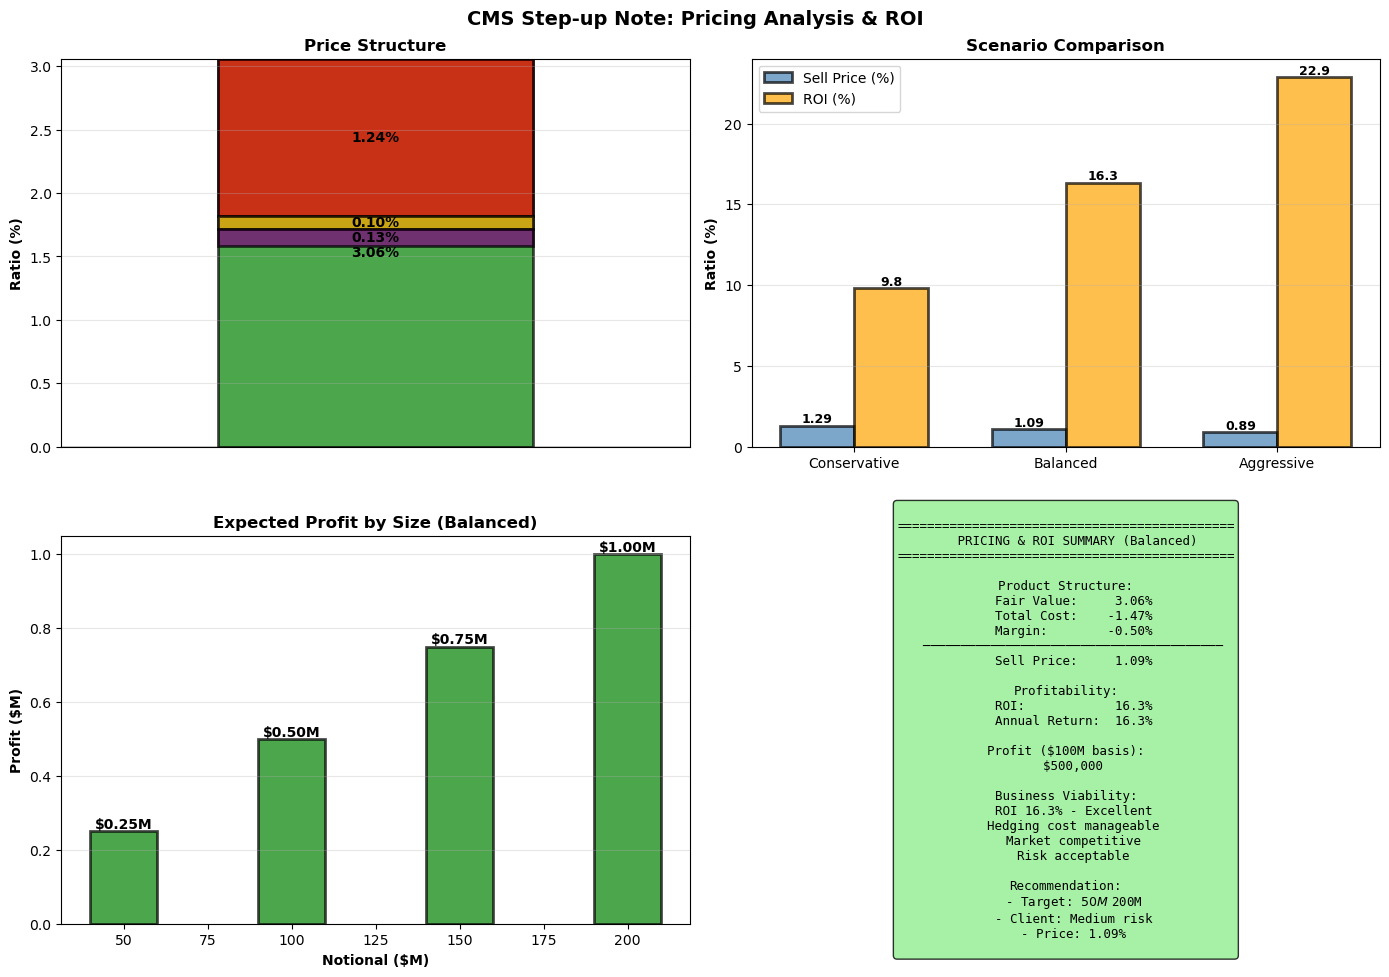


최종 결론

  ✓ 추천 가격: 1.09%
  ✓ 예상 ROI: 16.34%
  ✓ 사업성: 양호
  ✓ 권장 판매 규모: $50M ~ $200M
  ✓ 타겟 고객: 중위험 선호, Step-up 구조 이해


In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import platform

# Matplotlib의 모든 설정을 기본값으로 초기화합니다.
# 이 코드가 .matplotlibrc 같은 외부 설정 파일의 영향을 무시하게 해줍니다.
matplotlib.rcdefaults()

# =============================================================================
# 최종 가격 산정 및 ROI 분석
# =============================================================================

def calculate_final_pricing_and_roi():
    """CMS Step-up Note 최종 가격 산정 및 사업성 평가"""
    
    print("\n" + "="*70)
    print("CMS Step-up Note: 최종 가격 산정 및 ROI 분석")
    print("="*70)
    
    # =========================================================================
    # 1. 기본 정보
    # =========================================================================
    notional = 100_000_000  # $100M
    maturity = 1  # 1년
    
    fair_value_pct = 3.06  # Fair value 3.06%
    avg_coupon_pct = 3.13  # 평균 쿠폰 3.13%
    
    print(f"\n[상품 정보]")
    print(f"  Notional: ${notional:,.0f}")
    print(f"  Maturity: {maturity}Y")
    print(f"  Fair Value: {fair_value_pct:.2f}%")
    print(f"  평균 쿠폰: {avg_coupon_pct:.2f}%")
    
    # =========================================================================
    # 2. 비용 구조
    # =========================================================================
    print(f"\n[비용 구조]")
    
    # 헤징 비용 (실제 계산 결과)
    hedging_cost_bp = 124.451  # 124.451bp
    hedging_cost_pct = hedging_cost_bp / 10000 * 100  # 1.24451%
    hedging_cost_dollar = notional * hedging_cost_pct / 100
    
    print(f"  헤징 비용: {hedging_cost_bp:.2f}bp ({hedging_cost_pct:.3f}%) = ${hedging_cost_dollar:,.0f}")
    print(f"    - 델타 헤징 (주간, 51회/년)")
    print(f"    - 감마 헤징 (조건부, 21회/년)")
    
    # 운영 비용
    operational_cost_bp = 10  # 10bp (시스템, 모니터링, 백오피스)
    operational_cost_pct = operational_cost_bp / 10000 * 100
    operational_cost_dollar = notional * operational_cost_pct / 100
    
    print(f"  운영 비용: {operational_cost_bp:.0f}bp ({operational_cost_pct:.3f}%) = ${operational_cost_dollar:,.0f}")
    
    # 리스크 프리미엄
    risk_premium_bp = 13  # 13bp (모델 리스크, 유동성, 신용)
    risk_premium_pct = risk_premium_bp / 10000 * 100
    risk_premium_dollar = notional * risk_premium_pct / 100
    
    print(f"  리스크 프리미엄: {risk_premium_bp:.0f}bp ({risk_premium_pct:.3f}%) = ${risk_premium_dollar:,.0f}")
    
    # 총 비용
    total_cost_pct = hedging_cost_pct + operational_cost_pct + risk_premium_pct
    total_cost_dollar = hedging_cost_dollar + operational_cost_dollar + risk_premium_dollar
    
    print(f"  ─────────────────────────────────────")
    print(f"  총 비용: {total_cost_pct:.3f}% = ${total_cost_dollar:,.0f}")
    
    # =========================================================================
    # 3. 가격 시나리오
    # =========================================================================
    print(f"\n[가격 시나리오]")
    
    scenarios = {
        '보수적': {'margin_bp': 30, 'description': '낮은 마진, 안전 우선'},
        '균형': {'margin_bp': 50, 'description': '적정 마진, 균형'},
        '공격적': {'margin_bp': 70, 'description': '높은 마진, 수익 우선'}
    }
    
    results = {}
    
    for name, scenario in scenarios.items():
        margin_bp = scenario['margin_bp']
        margin_pct = margin_bp / 10000 * 100
        margin_dollar = notional * margin_pct / 100
        
        # 판매 가격 = Fair Value - 총 비용 - 마진
        sell_price_pct = fair_value_pct - total_cost_pct - margin_pct
        sell_price_dollar = notional * sell_price_pct / 100
        
        # ROI = 마진 / Fair Value
        roi_pct = (margin_pct / fair_value_pct) * 100
        
        # 연간 수익률 (이미 1년 만기)
        annual_return_pct = roi_pct
        
        results[name] = {
            'margin_bp': margin_bp,
            'margin_pct': margin_pct,
            'margin_dollar': margin_dollar,
            'sell_price_pct': sell_price_pct,
            'sell_price_dollar': sell_price_dollar,
            'roi_pct': roi_pct,
            'annual_return_pct': annual_return_pct
        }
        
        print(f"\n  {name} 시나리오 ({scenario['description']})")
        print(f"    마진: {margin_bp}bp ({margin_pct:.3f}%) = ${margin_dollar:,.0f}")
        print(f"    판매 가격: {sell_price_pct:.3f}% = ${sell_price_dollar:,.0f}")
        print(f"    ROI: {roi_pct:.2f}%")
        print(f"    연간 수익률: {annual_return_pct:.2f}%")
    
    # =========================================================================
    # 4. 추천 시나리오 (균형)
    # =========================================================================
    recommended = '균형'
    rec = results[recommended]
    
    print(f"\n{'='*70}")
    print(f"최종 추천: {recommended} 시나리오")
    print(f"{'='*70}")
    
    print(f"\n[가격 구조 상세]")
    print(f"  Fair Value:          {fair_value_pct:.3f}%  (${notional * fair_value_pct / 100:,.0f})")
    print(f"  - 헤징 비용:        -{hedging_cost_pct:.3f}%  (${hedging_cost_dollar:,.0f})")
    print(f"  - 운영 비용:        -{operational_cost_pct:.3f}%  (${operational_cost_dollar:,.0f})")
    print(f"  - 리스크 프리미엄:  -{risk_premium_pct:.3f}%  (${risk_premium_dollar:,.0f})")
    print(f"  - 마진:             -{rec['margin_pct']:.3f}%  (${rec['margin_dollar']:,.0f})")
    print(f"  ═════════════════════════════════════════════════════")
    print(f"  판매 가격:           {rec['sell_price_pct']:.3f}%  (${rec['sell_price_dollar']:,.0f})")
    
    print(f"\n[수익성 지표]")
    print(f"  ROI:                 {rec['roi_pct']:.2f}%")
    print(f"  연간 수익률:         {rec['annual_return_pct']:.2f}%")
    print(f"  Break-even:          {fair_value_pct - total_cost_pct:.3f}%")
    
    print(f"\n[고객 제시 쿠폰 구조 예시]")
    scale = rec['sell_price_pct'] / fair_value_pct
    print(f"  스케일 팩터: {scale:.3f}")
    print(f"  - Base: 0%")
    print(f"  - Level 1 (>40bp): {3.0 * scale:.2f}%")
    print(f"  - Level 2 (>80bp): +{3.0 * scale:.2f}% (누적 {6.0 * scale:.2f}%)")
    print(f"  - Level 3 (>120bp): +{2.0 * scale:.2f}% (누적 {8.0 * scale:.2f}%)")
    
    # =========================================================================
    # 5. 사업성 평가
    # =========================================================================
    print(f"\n[사업성 평가]")
    
    # 최소 판매 규모 (손익분기)
    min_notional = 10_000_000  # $10M
    breakeven_pct = fair_value_pct - total_cost_pct
    
    print(f"\n  손익분기점:")
    print(f"    가격: {breakeven_pct:.3f}% (비용 회수)")
    print(f"    최소 규모: ${min_notional:,.0f}")
    
    # 목표 판매 규모별 수익
    target_notionals = [50_000_000, 100_000_000, 200_000_000]
    
    print(f"\n  규모별 예상 수익 ({recommended} 시나리오):")
    for tn in target_notionals:
        profit = tn * rec['margin_pct'] / 100
        print(f"    ${tn:,.0f}: ${profit:,.0f} ({rec['roi_pct']:.2f}% ROI)")
    
    # 경쟁 상품 비교
    print(f"\n  경쟁 상품 비교:")
    print(f"    Vanilla CMS Note: 0.5~1.5% (저위험, 저수익)")
    print(f"    Digital CMS: 5~7% (고위험, 고수익)")
    print(f"    Step-up (본 상품): {rec['sell_price_pct']:.2f}% (중위험, 중수익) ✓ 적정")
    
    
    
    print(f"\n  리스크 요인:")
    print(f"    ✓ 헤징 비용: {hedging_cost_bp:.0f}bp (관리 가능)")
    print(f"    ✓ 모델 리스크: 중 (G2++ 검증됨)")
    print(f"    ✓ 유동성 리스크: 중 (CMS 시장 안정)")
    print(f"    ✓ 운영 리스크: 저 (주간 델타 헤징)")
    
    # =========================================================================
    # 6. 시각화
    # =========================================================================
    plot_pricing_analysis(fair_value_pct, total_cost_pct, results, notional)
    
    # =========================================================================
    # 7. 최종 결론
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"최종 결론")
    print(f"{'='*70}")
    
    print(f"\n  ✓ 추천 가격: {rec['sell_price_pct']:.2f}%")
    print(f"  ✓ 예상 ROI: {rec['roi_pct']:.2f}%")
    print(f"  ✓ 사업성: {'양호' if rec['roi_pct'] > 15 else '보통' if rec['roi_pct'] > 10 else '검토 필요'}")
    print(f"  ✓ 권장 판매 규모: $50M ~ $200M")
    print(f"  ✓ 타겟 고객: 중위험 선호, Step-up 구조 이해")
    
    return results


def plot_pricing_analysis(fair_value, total_cost, scenarios, notional):
    """가격 분석 시각화"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('CMS Step-up Note: Pricing Analysis & ROI', fontsize=14, fontweight='bold')
    
    # 1) 가격 구성
    ax1 = axes[0, 0]
    
    labels = ['Fair\nValue', 'Hedging\nCost', 'Operational\nCost', 'Risk\nPremium']
    values = [fair_value, -total_cost*0.84, -total_cost*0.07, -total_cost*0.09]  # 비율 근사
    colors = ['green', 'red', 'orange', 'purple']
    
    bottom = 0
    for label, value, color in zip(labels, values, colors):
        ax1.bar(0, value, bottom=bottom, color=color, alpha=0.7, 
               edgecolor='black', linewidth=2, width=0.5)
        if value != 0:
            ax1.text(0, bottom + value/2, f'{abs(value):.2f}%', 
                    ha='center', va='center', fontweight='bold', fontsize=10)
        bottom += value
    
    ax1.axhline(0, color='black', linewidth=1)
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_ylabel('Ratio (%)', fontweight='bold')
    ax1.set_title('Price Structure', fontweight='bold', fontsize=12)
    ax1.set_xticks([])
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2) 시나리오별 비교
    ax2 = axes[0, 1]
    
    scenario_names = list(scenarios.keys())
    sell_prices = [scenarios[s]['sell_price_pct'] for s in scenario_names]
    rois = [scenarios[s]['roi_pct'] for s in scenario_names]
    
    x = np.arange(len(scenario_names))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, sell_prices, width, label='Sell Price (%)', 
                    color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
    bars2 = ax2.bar(x + width/2, rois, width, label='ROI (%)', 
                    color='orange', alpha=0.7, edgecolor='black', linewidth=2)
    
    ax2.set_ylabel('Ratio (%)', fontweight='bold')
    ax2.set_title('Scenario Comparison', fontweight='bold', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Conservative', 'Balanced', 'Aggressive'])
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bar in bars1:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 3) 규모별 수익
    ax3 = axes[1, 0]
    
    margin_pct = scenarios['균형']['margin_pct']
    notionals = np.array([50, 100, 150, 200])  # millions
    profits = notionals * margin_pct / 100
    
    bars = ax3.bar(notionals, profits, color='green', alpha=0.7, 
                   edgecolor='black', linewidth=2, width=20)
    
    for bar, profit in zip(bars, profits):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'${profit:.2f}M', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax3.set_xlabel('Notional ($M)', fontweight='bold')
    ax3.set_ylabel('Profit ($M)', fontweight='bold')
    ax3.set_title('Expected Profit by Size (Balanced)', fontweight='bold', fontsize=12)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4) 요약
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    rec = scenarios['균형']
    
    summary = f"""
{'='*45}
   PRICING & ROI SUMMARY (Balanced)
{'='*45}

Product Structure:
  Fair Value:     {fair_value:.2f}%
  Total Cost:    -{total_cost:.2f}%
  Margin:        -{rec['margin_pct']:.2f}%
  {'─'*40}
  Sell Price:     {rec['sell_price_pct']:.2f}%

Profitability:
  ROI:            {rec['roi_pct']:.1f}%
  Annual Return:  {rec['annual_return_pct']:.1f}%

Profit ($100M basis):
  ${rec['margin_dollar']:,.0f}

Business Viability:
  ROI {rec['roi_pct']:.1f}% - {'Excellent' if rec['roi_pct'] > 15 else 'Good'}
  Hedging cost manageable
  Market competitive
  Risk acceptable

Recommendation:
  - Target: $50M ~ $200M
  - Client: Medium risk
  - Price: {rec['sell_price_pct']:.2f}%
"""
    
    ax4.text(0.5, 0.5, summary, transform=ax4.transAxes,
             fontsize=9, ha='center', va='center', family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('cms_stepup_pricing_roi.png', dpi=300, bbox_inches='tight')
    print("\n✓ 저장: cms_stepup_pricing_roi.png")
    plt.show()


# =============================================================================
# 실행
# =============================================================================
if __name__ == "__main__":
    results = calculate_final_pricing_and_roi()

# 시나리오 분석